<H1>Patient's mortality prediction from 24 hours of ICU data</H1>

Source: https://www.kaggle.com/c/widsdatathon2020/data

1. Objective: Predict the survival of the patient based on the first 24 hours data from Intesive Care Unit (ICU) in a hospital

2. Mapping real world problem to ML problem
  
  2.1 Type of machine learning problem:
        The output is binary and thus this is a binary classification
  2.2 Metric for performance model
       - Logistic loss is the primary performance metric
       - Area under the Receiver Operating Characteristic (ROC) curve is the secondary performance metric. ROC-AUC is the performance metric requested by Kaggle
      
       

3. Exploratory Data Analysis
    3.1 Understanding Features
    3.2 Exploration of APACHE 4 probabilistic prediction values and its correlation with hospital death
    

1. Variance threshold = 0.1
     Columns removed: 'readmission_status' 'gcs_unable_apache' 'ph_apache' 'd1_arterial_ph_max'
     'aids' 'leukemia' 'lymphoma'

2. Features with >90% of the data is missing:
    Columns removed: 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
    'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'

3. Split features and target variable

4. Split test, train dataset

5. Create dummy variables for categorical variables

6. Standardize features except categorical variables

7. Impute median in missing values position

In [2]:
### Importing required modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn import pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
#from xgboost import XGBClassifier

In [4]:
## Load csv file into pandas
df = pd.read_csv("/Users/archana/Documents/python Notebooks/Kaggle Project /ICU diagnosis/widsdatathon2020/training_v2.csv")
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


3. Exploratory Data Analysis<br>
    3.1 Dividing features as per feature category 
        3.1.1 id features 
            - Univariate analysis
            - Relation with target variable
            - Correlation between variables
        3.1.2 d1/h1 features
            - Univariate analysis
            - Relation with target variable
            - Correlation between variables
        3.1.2 apache co-variate features
            - Univariate analysis
            - Relation with target variable
            - Correlation between variables
        3.1.2 res of the features
            - Univariate analysis
            - Relation with target variable
            - Correlation between variables
    3.2 Imbalance dataset?

In [5]:
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
encounter_id                     91713 non-null int64
patient_id                       91713 non-null int64
hospital_id                      91713 non-null int64
hospital_death                   91713 non-null int64
age                              87485 non-null float64
bmi                              88284 non-null float64
elective_surgery                 91713 non-null int64
ethnicity                        90318 non-null object
gender                           91688 non-null object
height                           90379 non-null float64
hospital_admit_source            70304 non-null object
icu_admit_source                 91601 non-null object
icu_id                           91713 non-null int64
icu_stay_type                    91713 non-null object
icu_type                         91713 non-null object
pre_icu_los_days                 91713 non-null float64
readmission_

- There are 91713 observations with 186 features in the dataset. 
- Out of 186 features, 8 are categorical features
- Features can be grouped into five categories:
    - ID
    - Rest (Chronic health condition, admission status)
    - apache values (Apache 4 scores)
    - d1 -- Patient's vital or lab measured during the first 24 hours (d1 - day1)
    - h1 -- Patient's vital or lab measured during the first hour (h1 - hour 1)

What does APACHE mean?

Reference: https://www.merckmanuals.com/professional/critical-care-medicine/approach-to-the-critically-ill-patient/critical-care-scoring-systems

Acute Physiologic Assessment and Chronic Health Evaluation (APACHE)

Three versions of APACHE scores are available
APACHE II
APACHE III
APACHE IV

APACHE scores were calculated based on patient's physiological and other health conditions to estimate ICU mortality

<I>"APACHE scores were developed to grade the severity of illness in critically ill patients. These systems are moderately accurate in predicting individual survival. However, these systems are more valuable for monitoring quality of care and for conducting research studies because they allow comparison of outcomes among groups of critically ill patients with similar illness severity." </I>

From the dictionary provided, it is clear that the following 2 features provides the probability of patient's mortality (apache 4 scores) for in hospital and in ICU respectively:
    - apache_4a_hospital_death_prob 
    - apache_4a_icu_death_prob

3.1 Understanding Features:

In [6]:
### Separating features by feature categories identified above
print("#"*20 + "Features with id" + "#"*20)
id_features = df.columns[df.columns.str.endswith('id')]
print(id_features)
print("#"*20 + "apache values" + "#"*20)
apache_features = df.columns[df.columns.str.contains('apache')]
print(apache_features)
print("#"*20 + "d1 values" + "#"*20)
d1_features = df.columns[df.columns.str.contains('d1')]
print(d1_features)
print("#"*20 + "h1 values" + "#"*20)
h1_features = df.columns[df.columns.str.contains('h1')]
print(h1_features)
print("#"*20 + "Rest of features" + "#"*20)
rest_features = df.columns[~df.columns.str.contains("|".join(['id$','apache','d1','h1']))]
print(rest_features)

####################Features with id####################
Index(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'], dtype='object')
####################apache values####################
Index(['albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'apache_3j_bodysystem', 'apache_2_bodysystem'],
      dtype='object')
####################d1 values####################
Index(['d1_diasbp_invasive_max', 'd1_

Out of 186 features, 128 features contains values for patient's vitals, labs and lab blood gas. here are the details of these variables:

- For each of the vital/lab, two measurements are recorded (maximum and minimum) and are reported as 2 features
- Every one of the vital/lab measurements are performed twice: after the 1st hour in ICU (feature name starting with h1_ ) and after 24hrs in ICU (feature name starting with d1_). 
- Thus for every vital/lab, there are four features. For example, for diastolic noninvasive blood pressure, 
    - h1_diasbp_noninvasive_min (minimum value, after 1st hour in ICU)
    - h1_diasbp_noninvasive_max (maximum value, after 1st hour in ICU)
    - d1_diasbp_noninvasive_min (minimum value, after 24 hours in ICU)
    - d1_diasbp_noninvasive_max (maximum value, after 24 hours in ICU) 
- There are 124/4 = 31 vital/lab parameters measured 
     
For blood pressure - (diastolic, systolic and mean), there are 6 measurements as follows:

1. Measured via invasive technique: maximum measured value
2. Measured via invasive technique: minimum measured value
3. Measured via non-invasive technique: maximum measured value
4. Measured via non-invasive technique: minimum measured value
5. Maximum of invasive and non-invasive
6. Minimum of invasive and non-invasive

encounter_id    91713
patient_id      91713
hospital_id       147
icu_id            241
dtype: int64
Following hospital ID have zero deaths reported. Note that the number of observations from these hospitals is also less


,sum,count
hospital_id,,
4,0,7
38,0,10
43,0,173
66,0,22
72,0,15
85,0,133
93,0,6
95,0,6
111,0,200


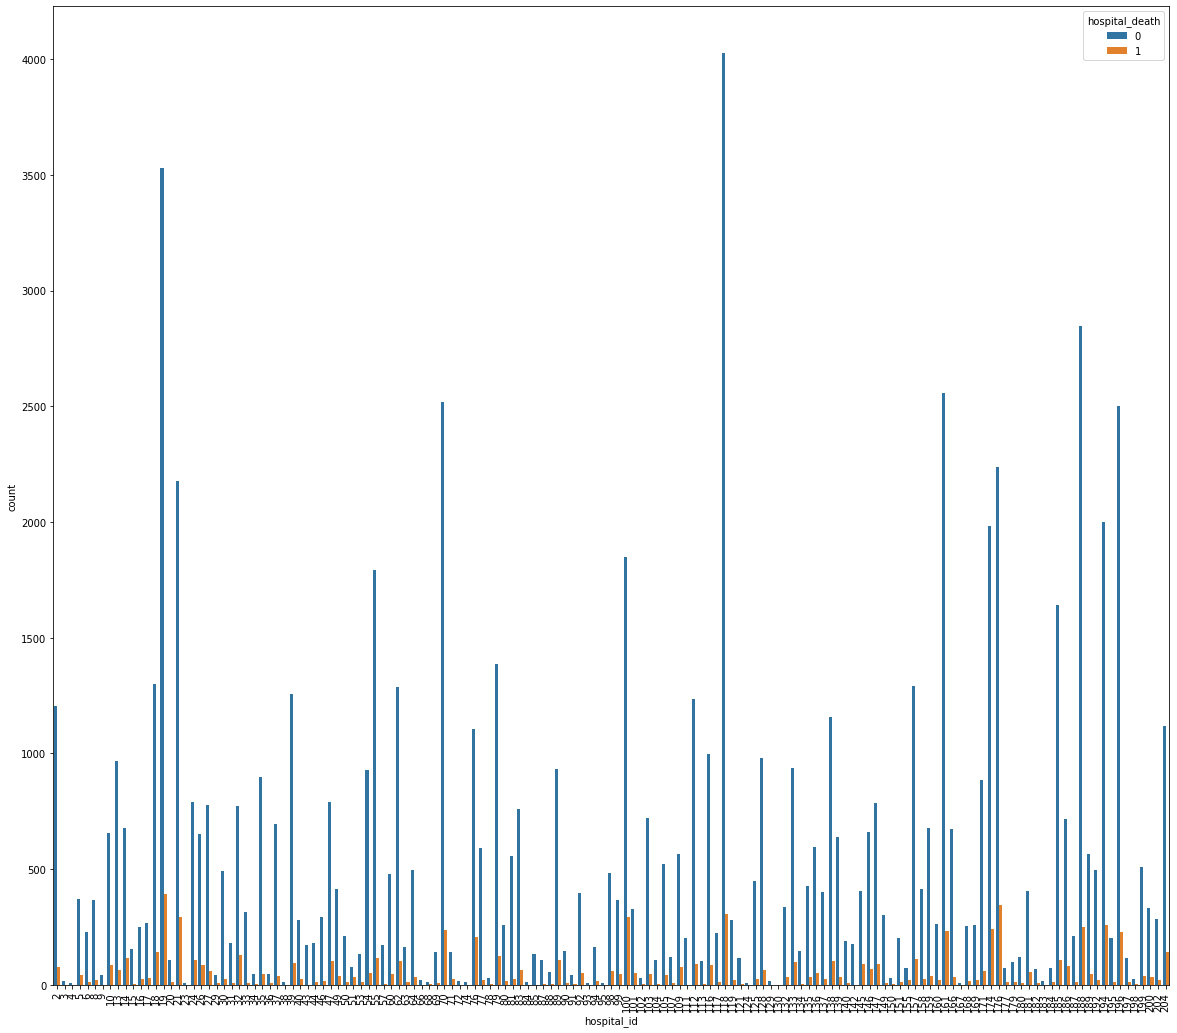

In [58]:
#### Exploring features with ID
print(df[id_features].nunique())
plt.figure(figsize = (20,18))
sns.countplot(df.hospital_id, hue = df.hospital_death)
plt.xticks(rotation = 90)
hospital_id_df = df.groupby('hospital_id')['hospital_death'].agg(['sum', 'count'])
print("Following hospital ID have zero deaths reported. Note that the number of observations from these hospitals is also less")
hospital_id_df[hospital_id_df['sum']==0]

In [61]:
#Is there a unique combination of hospital id and icu id

t = df.groupby('icu_id')['hospital_death'].agg(['sum', 'count'])
t[t['sum'] == 0]

,sum,count
icu_id,,
153,0,7
158,0,9
195,0,133
230,0,6
241,0,1
242,0,8
338,0,19
389,0,15
494,0,3


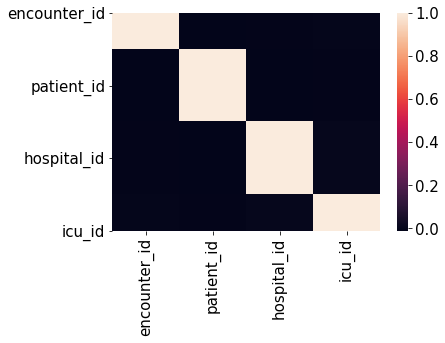

In [95]:
sns.heatmap(df[id_features].corr())

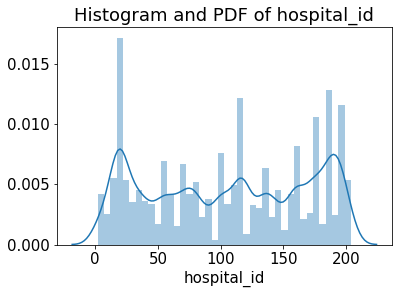

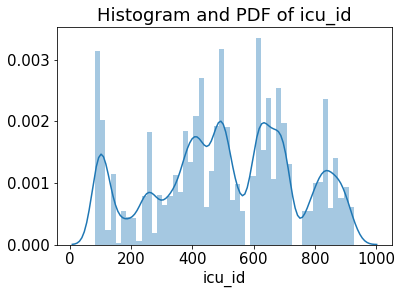

In [99]:
plt.title("Histogram and PDF of hospital_id")
sns.distplot(df.hospital_id)
plt.show()
plt.title("Histogram and PDF of icu_id")
sns.distplot(df.icu_id)
plt.show()


- Patient and encounter id are unique values for all records and thus they can be dropped
- there are 147 hospital ids with 241 ICUs
- No linear correlation between id features
- There are 10 hospital ids for which there are no deaths reported

In [113]:
drop_features = ['patient_id', 'encounter_id']

In [62]:
### Exploring features with d1 and h1 vital and lab measurements

In [66]:
df_d1_h1 = df[df.columns[df.columns.str.contains("h1|d1")]]
df_d1_h1[df_d1_h1.columns[df_d1_h1.columns.str.contains('h1.*bp.*invasive')]]

,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min
0,NaN,NaN,68.0,63.0,NaN,NaN,86.0,85.0,NaN,NaN,131.0,115.0
1,NaN,NaN,61.0,48.0,NaN,NaN,85.0,57.0,NaN,NaN,95.0,71.0
2,NaN,NaN,88.0,58.0,NaN,NaN,91.0,83.0,NaN,NaN,148.0,124.0
3,62.0,44.0,NaN,NaN,92.0,71.0,NaN,NaN,136.0,106.0,NaN,NaN
4,NaN,NaN,99.0,68.0,NaN,NaN,104.0,92.0,NaN,NaN,130.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91708,NaN,NaN,55.0,44.0,NaN,NaN,64.0,55.0,NaN,NaN,94.0,87.0
91709,NaN,NaN,64.0,56.0,NaN,NaN,78.0,68.0,NaN,NaN,127.0,107.0
91710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#Understanding pattern of missing values
print("List of missing value")
print(df_d1_h1.isnull().sum())
#    
index = df_d1_h1.columns
for i in range(0,len(df_d1_h1.columns),2):
    print(" ".join(index[i].split('_')[1:-1]))
    print(df_d1_h1[index[i]][df_d1_h1[index[i+1]].isnull()].sum())


List of missing value
d1_diasbp_invasive_max       67984
d1_diasbp_invasive_min       67984
d1_diasbp_max                  165
d1_diasbp_min                  165
d1_diasbp_noninvasive_max     1040
                             ...  
h1_arterial_ph_min           76424
h1_arterial_po2_max          75945
h1_arterial_po2_min          75945
h1_pao2fio2ratio_max         80195
h1_pao2fio2ratio_min         80195
Length: 128, dtype: int64
diasbp invasive
0.0
diasbp
0.0
diasbp noninvasive
0.0
heartrate
0.0
mbp invasive
0.0
mbp
0.0
mbp noninvasive
0.0
resprate
0.0
spo2
0.0
sysbp invasive
0.0
sysbp
0.0
sysbp noninvasive
0.0
temp
0.0
diasbp invasive
0.0
diasbp
0.0
diasbp noninvasive
0.0
heartrate
0.0
mbp invasive
0.0
mbp
0.0
mbp noninvasive
0.0
resprate
0.0
spo2
0.0
sysbp invasive
0.0
sysbp
0.0
sysbp noninvasive
0.0
temp
0.0
albumin
0.0
bilirubin
0.0
bun
0.0
calcium
0.0
creatinine
0.0
glucose
0.0
hco3
0.0
hemaglobin
0.0
hematocrit
0.0
inr
0.0
lactate
0.0
platelets
0.0
potassium
0.0
sodium
0.0
wbc
0.

- For a vital/lab parameter, the max and min features have the same number of missing values
- For any vital/lab feature, if max value is missing, then its min value is also missing
- So, we can safely impute mean or median for missing values

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly c

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly c

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly c

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly c

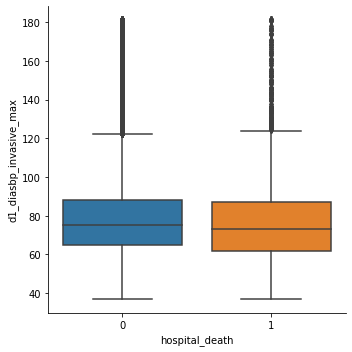

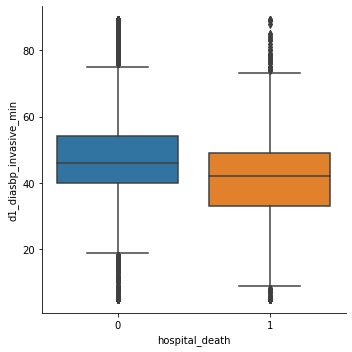

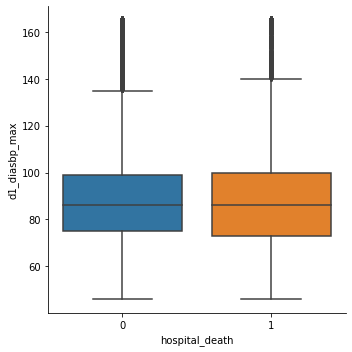

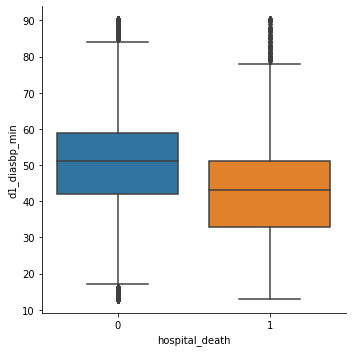

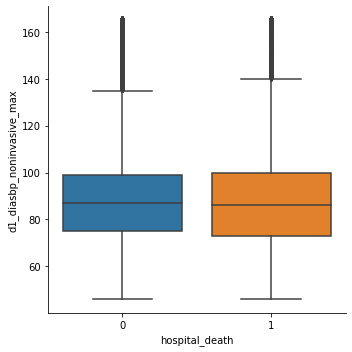

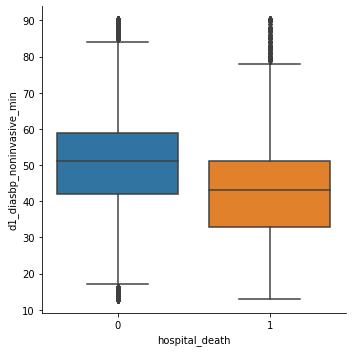

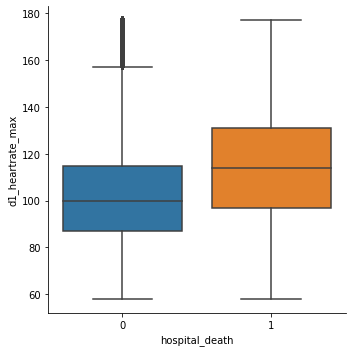

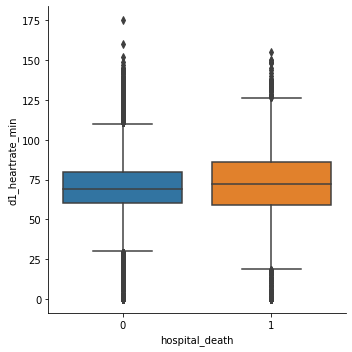

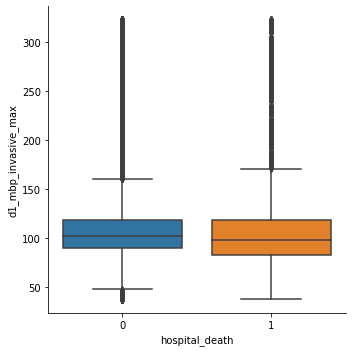

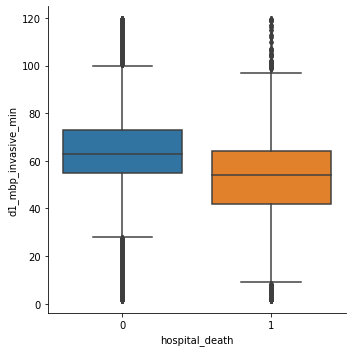

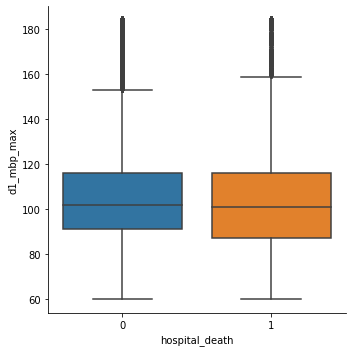

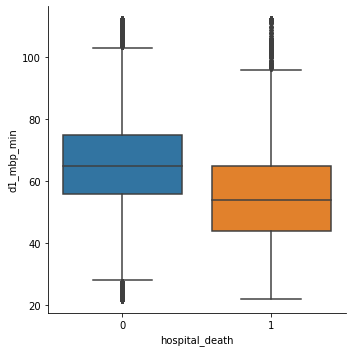

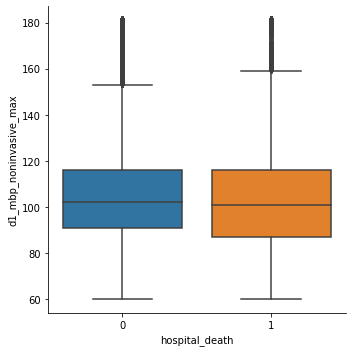

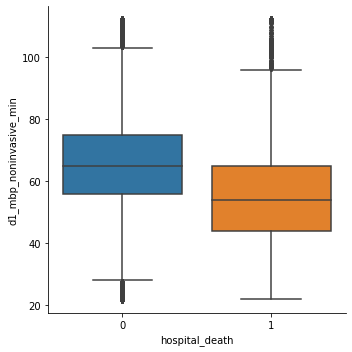

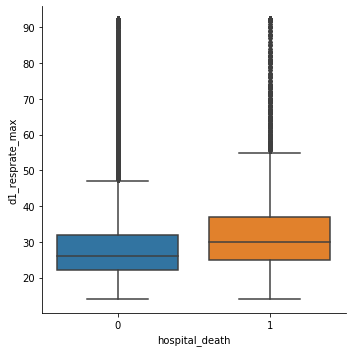

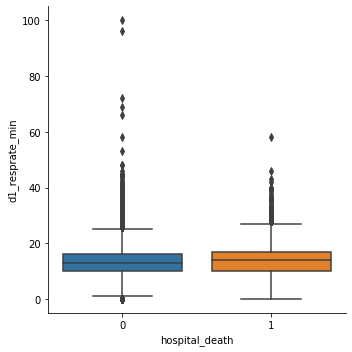

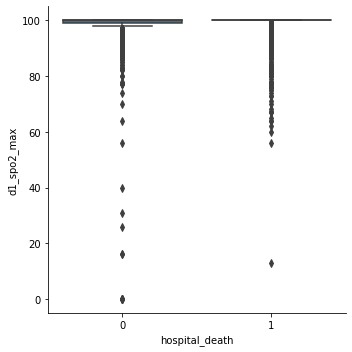

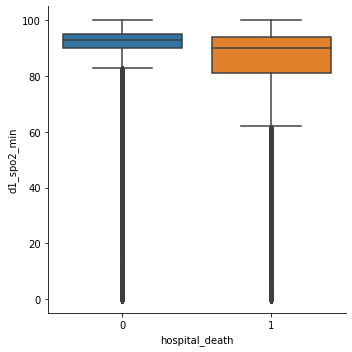

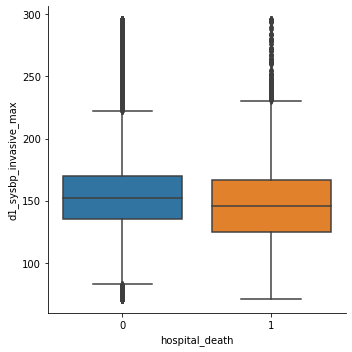

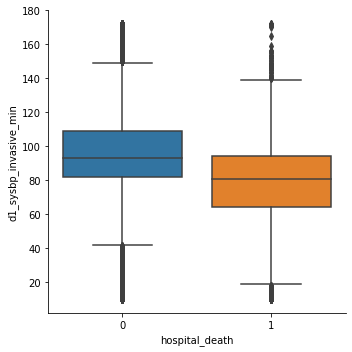

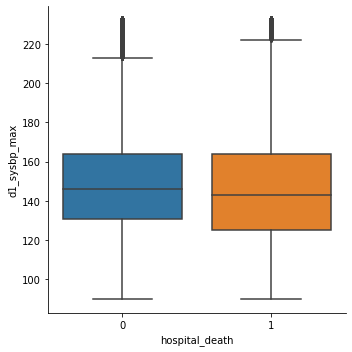

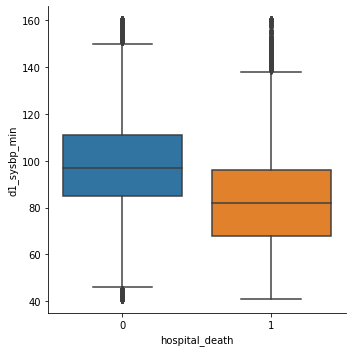

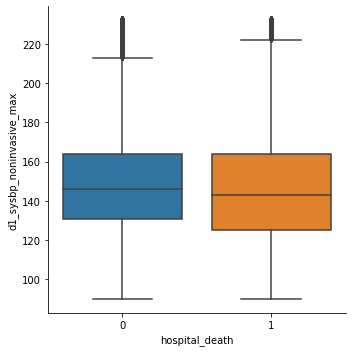

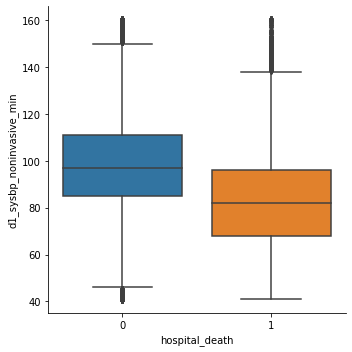

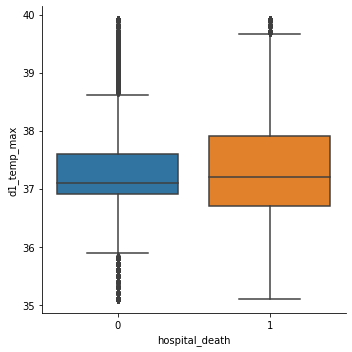

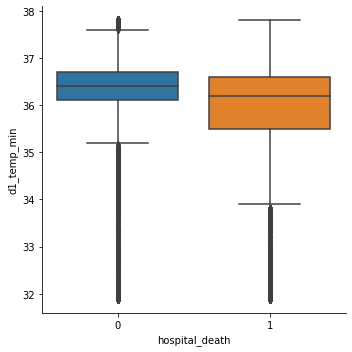

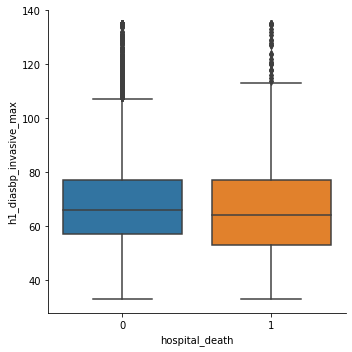

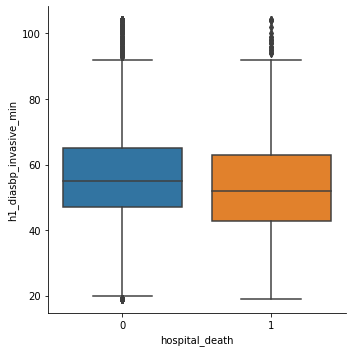

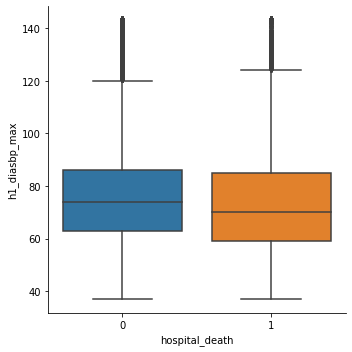

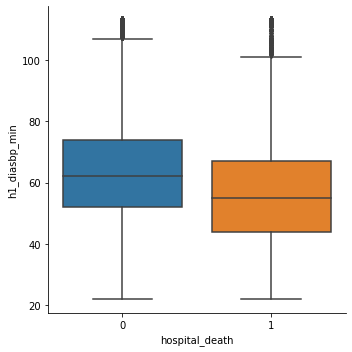

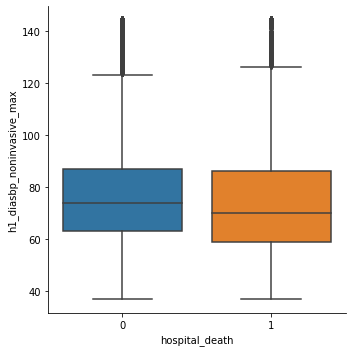

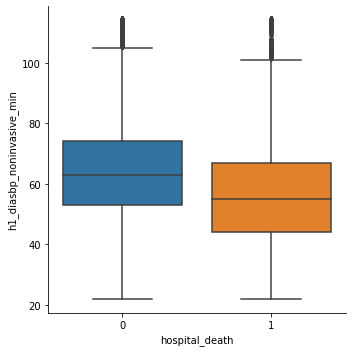

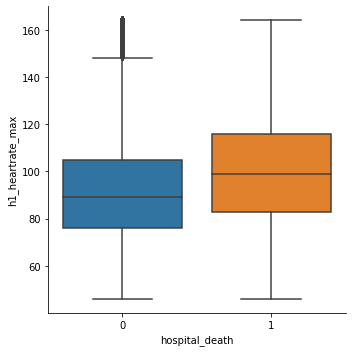

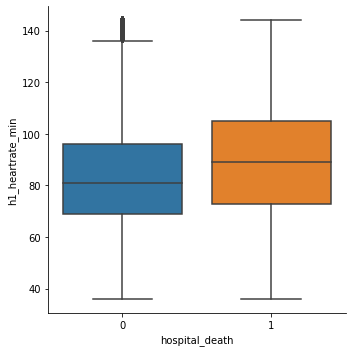

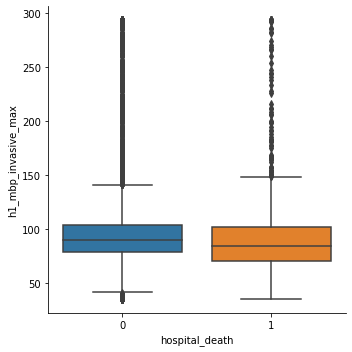

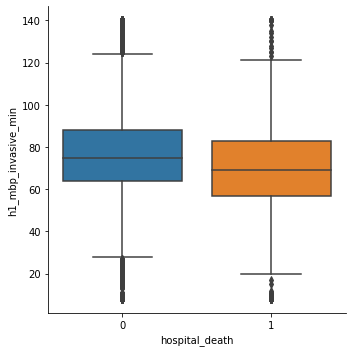

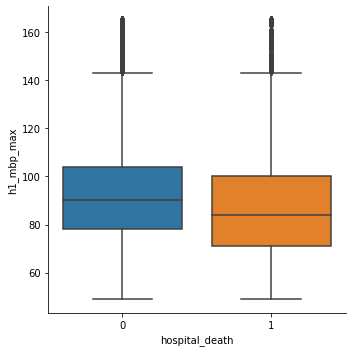

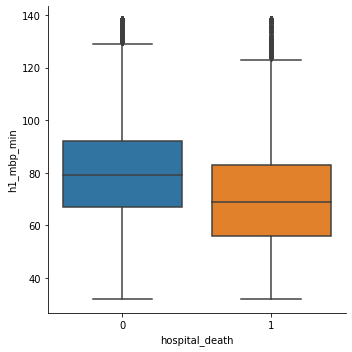

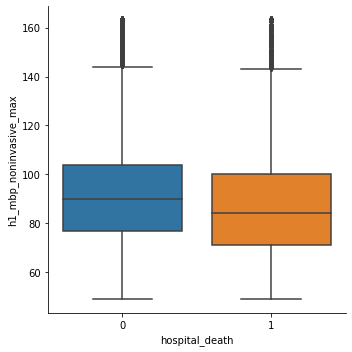

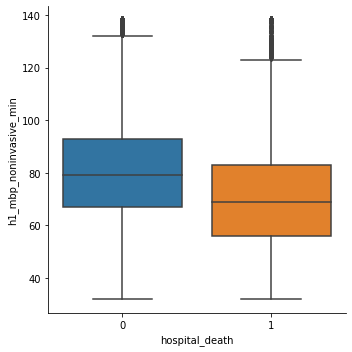

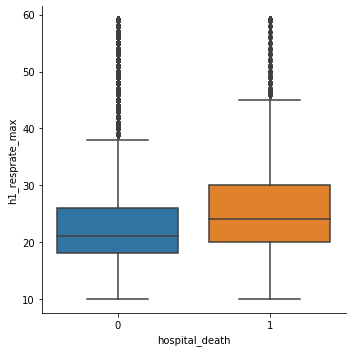

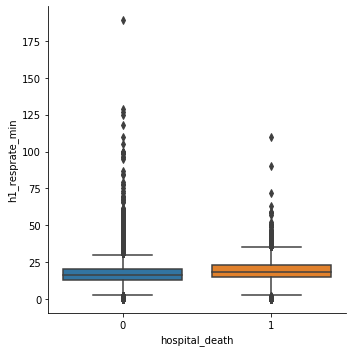

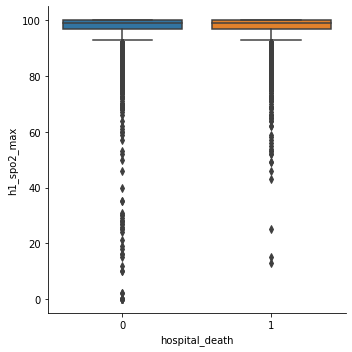

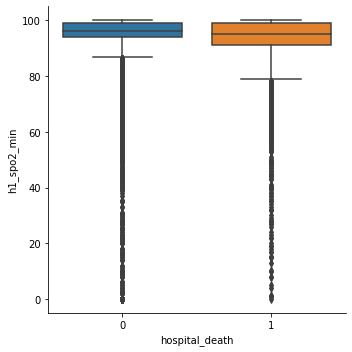

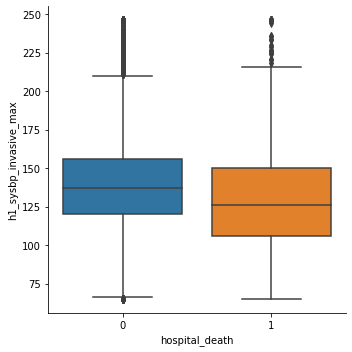

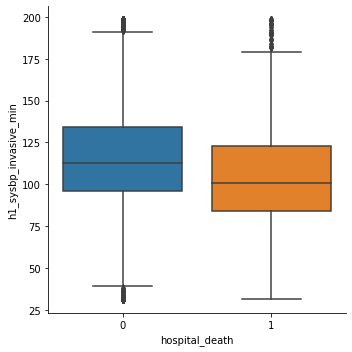

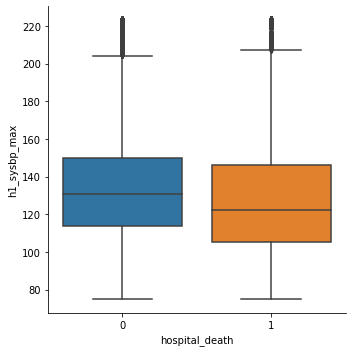

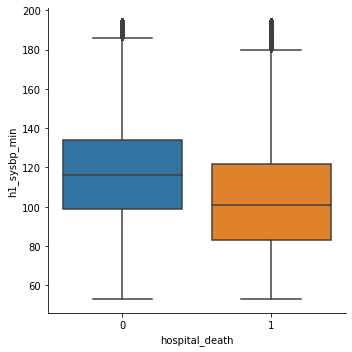

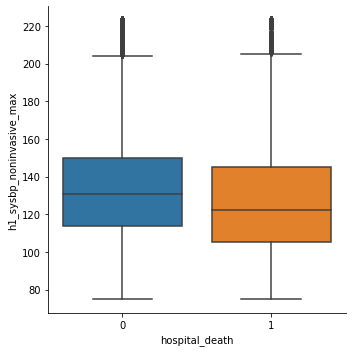

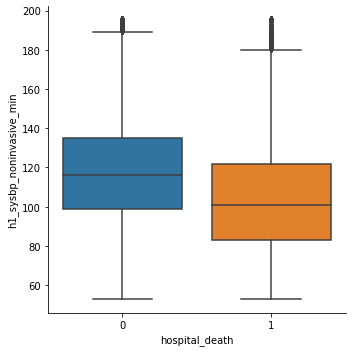

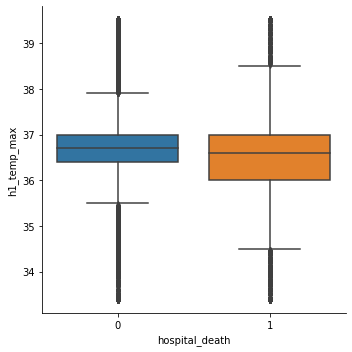

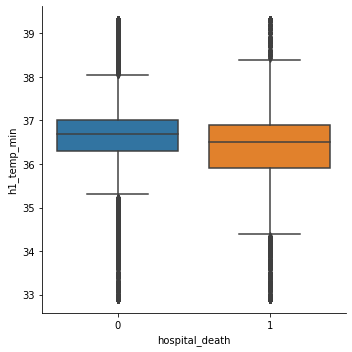

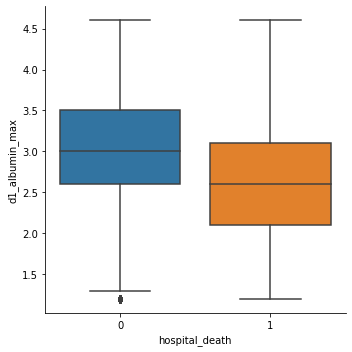

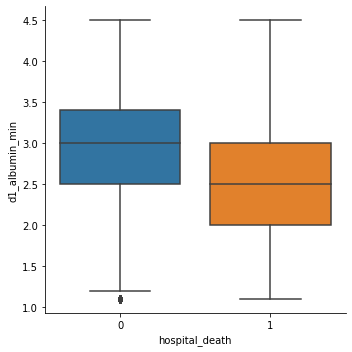

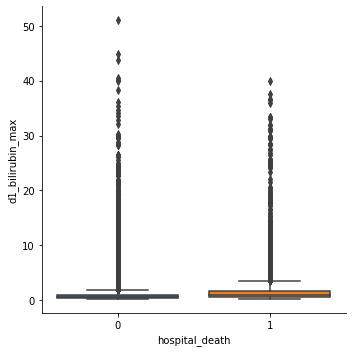

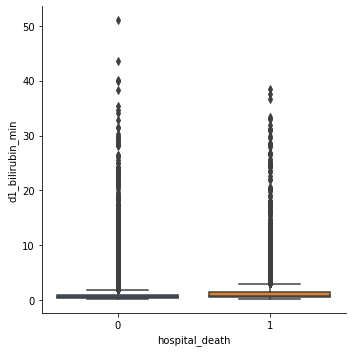

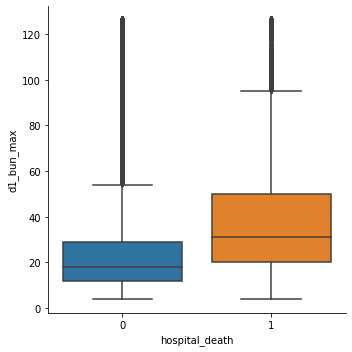

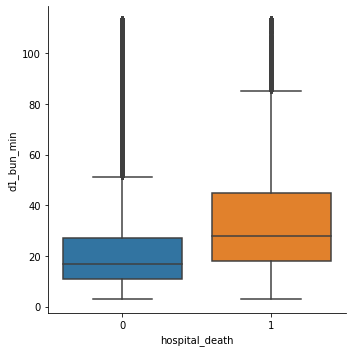

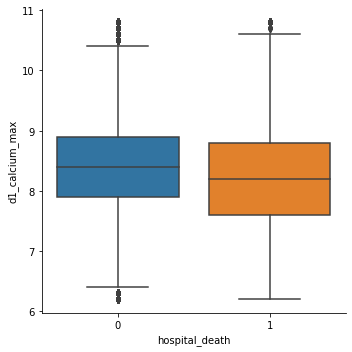

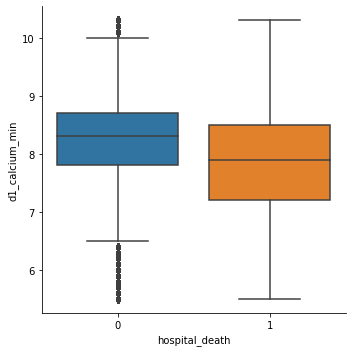

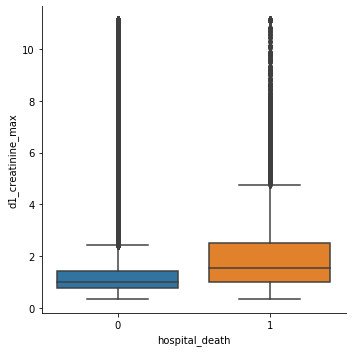

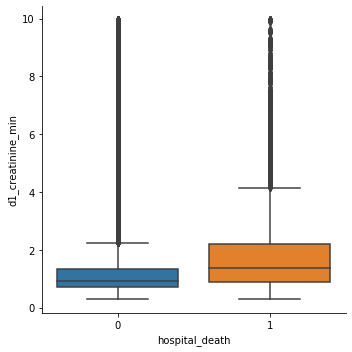

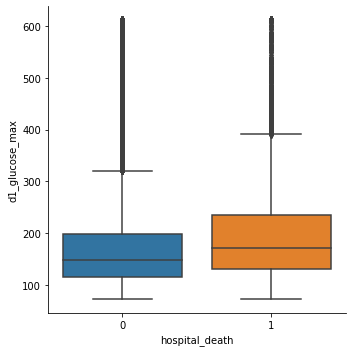

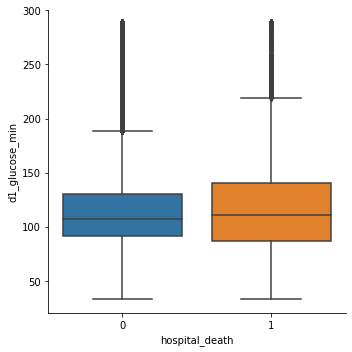

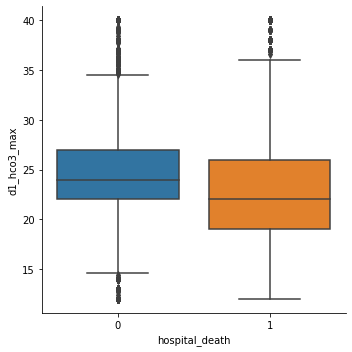

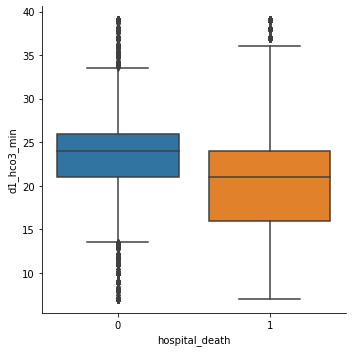

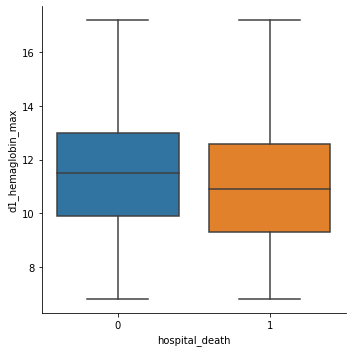

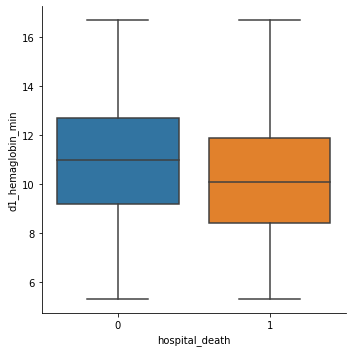

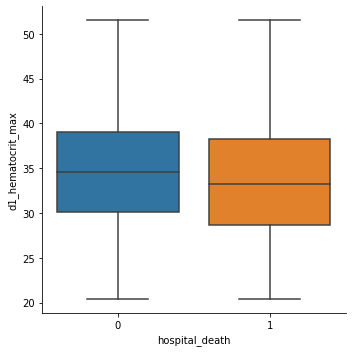

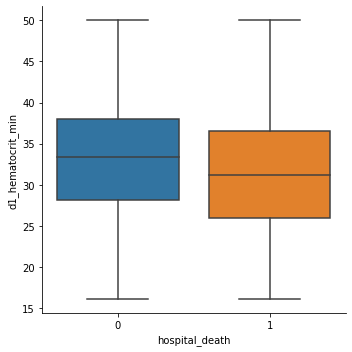

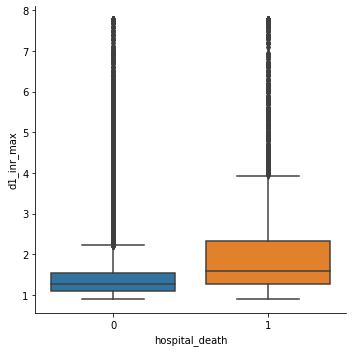

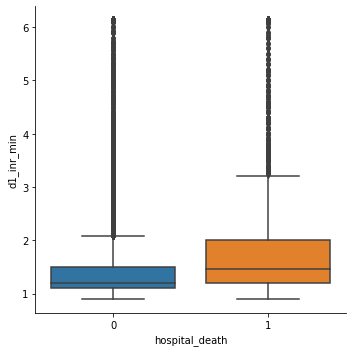

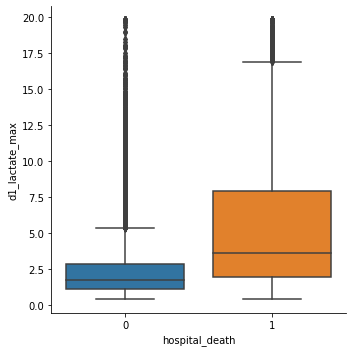

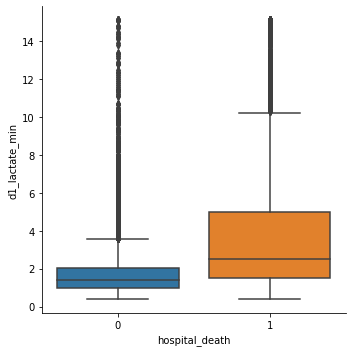

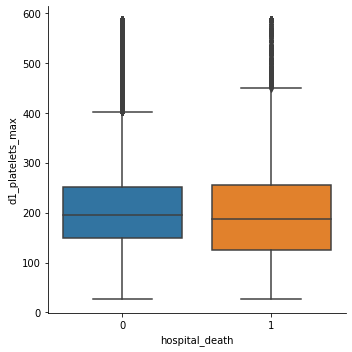

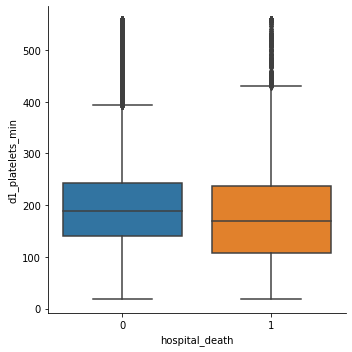

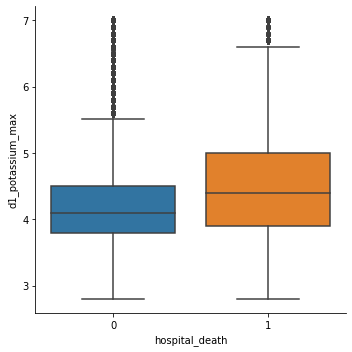

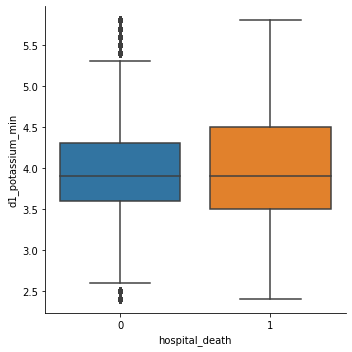

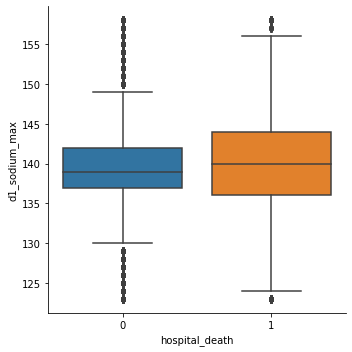

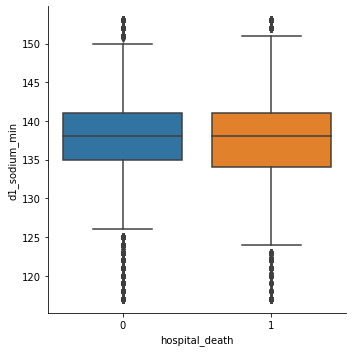

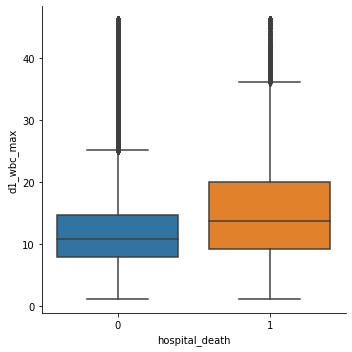

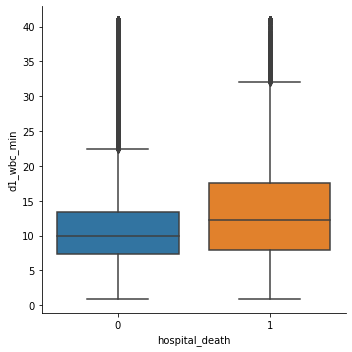

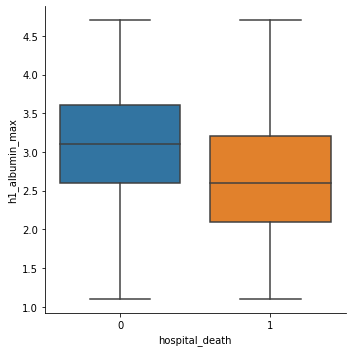

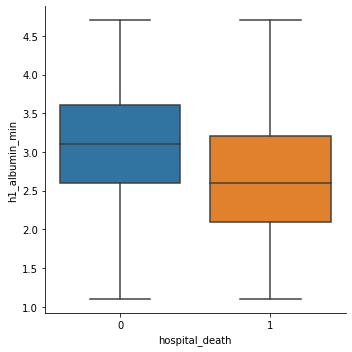

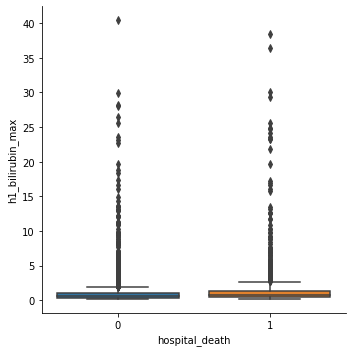

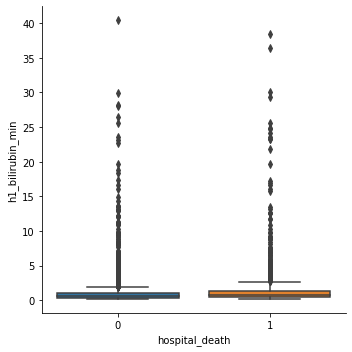

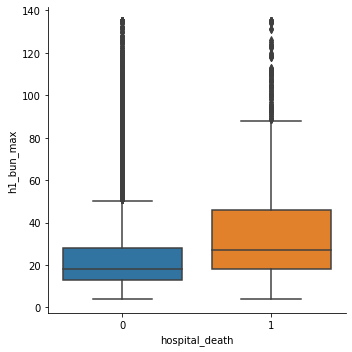

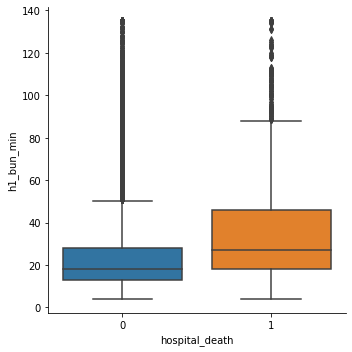

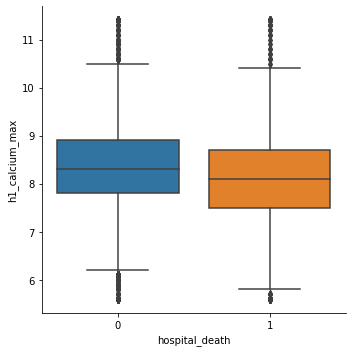

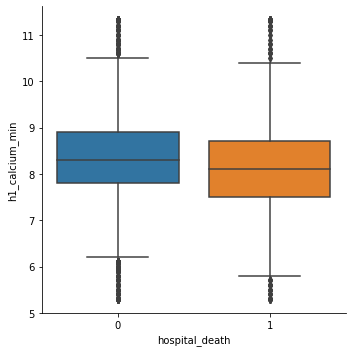

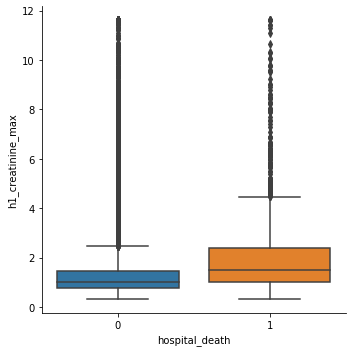

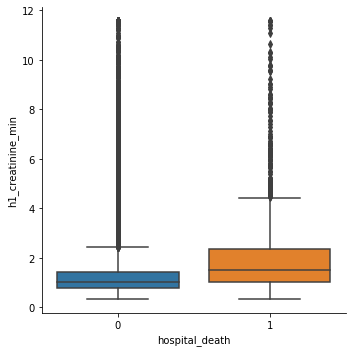

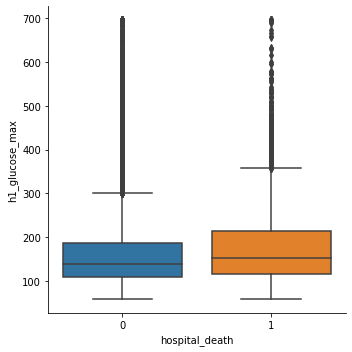

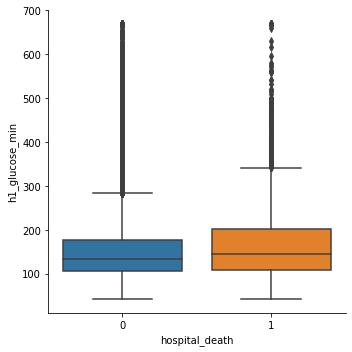

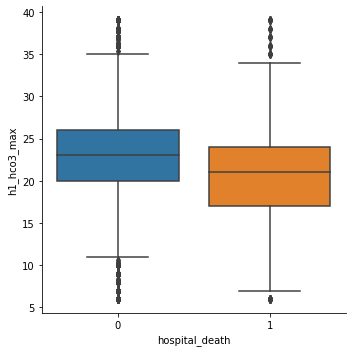

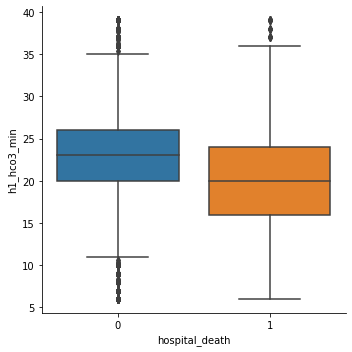

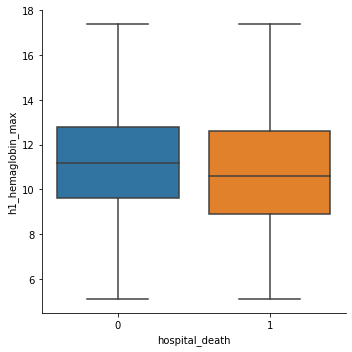

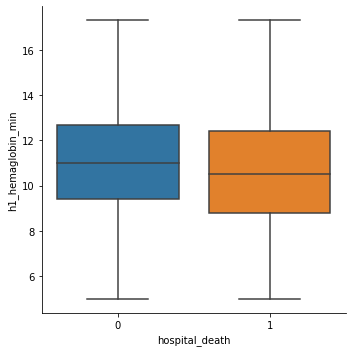

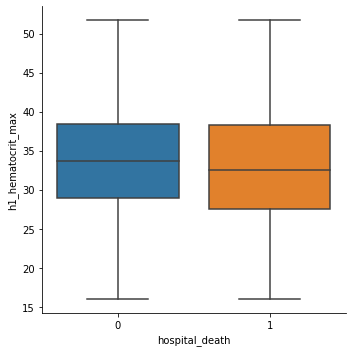

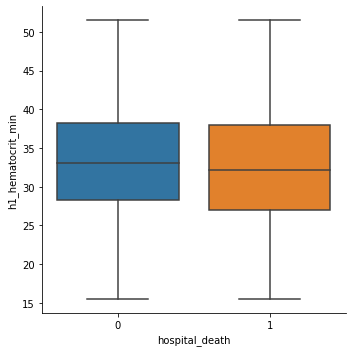

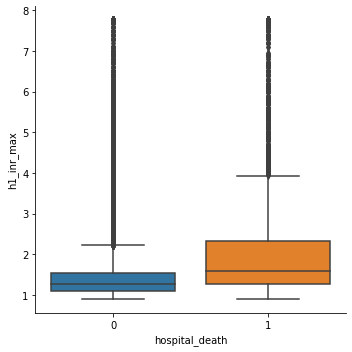

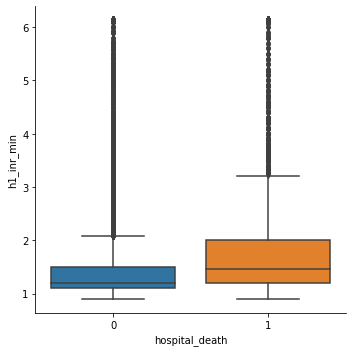

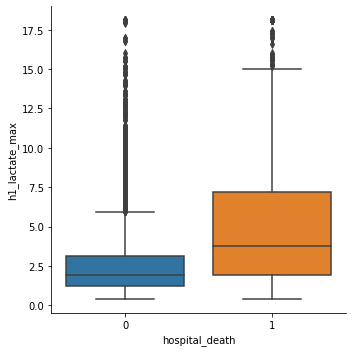

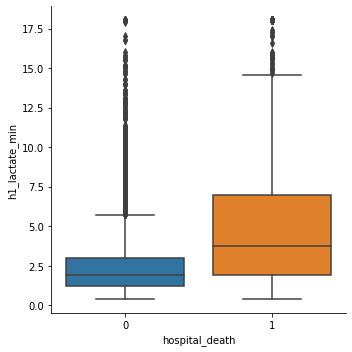

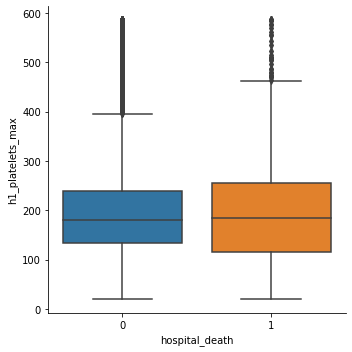

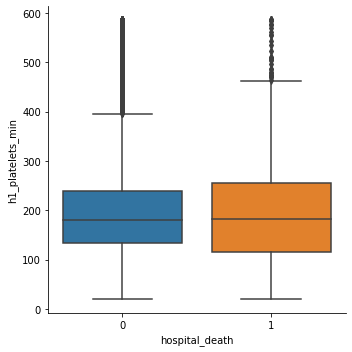

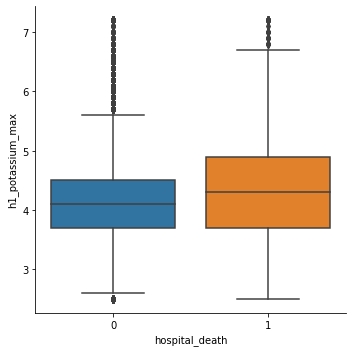

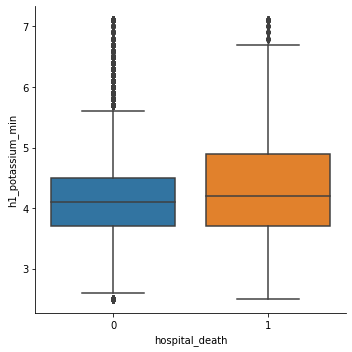

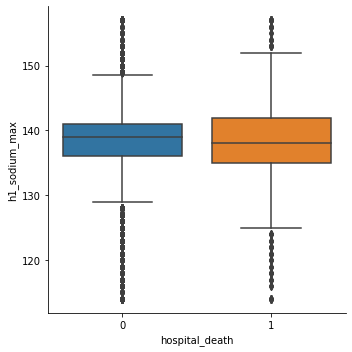

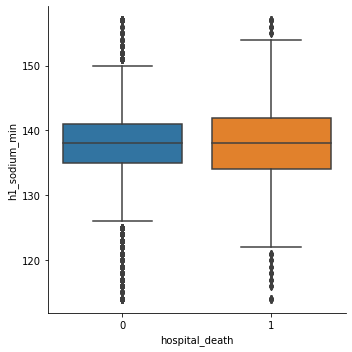

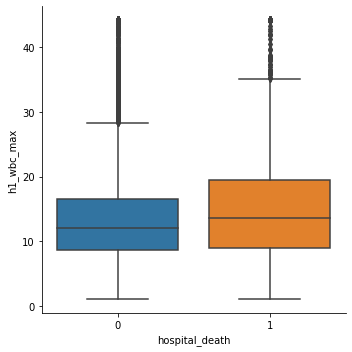

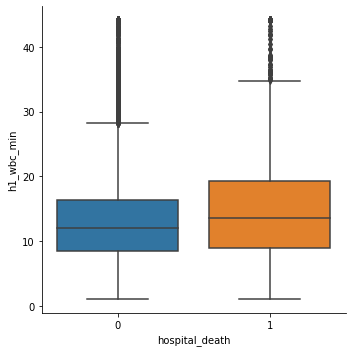

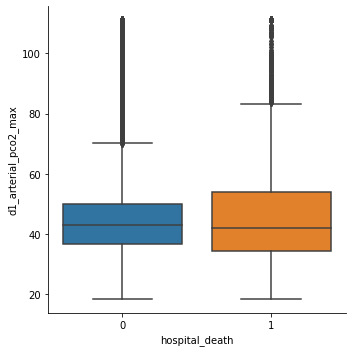

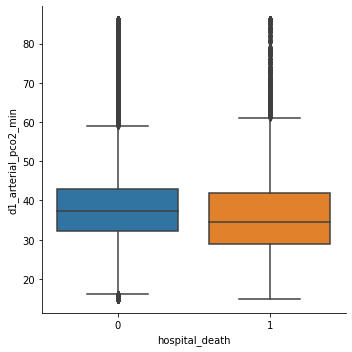

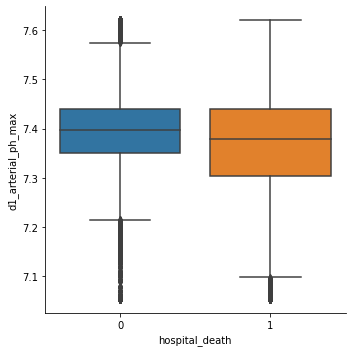

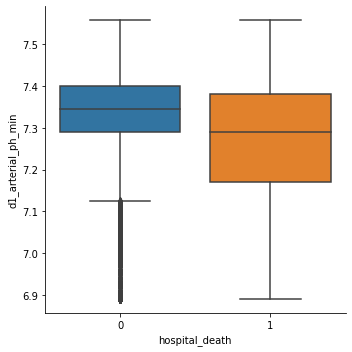

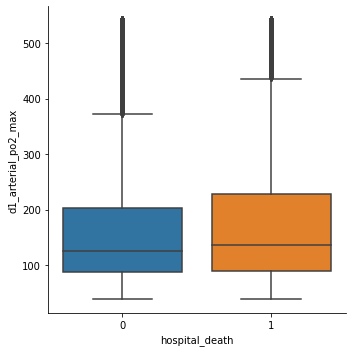

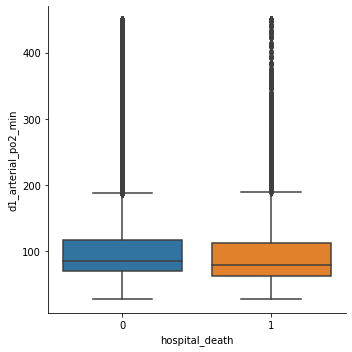

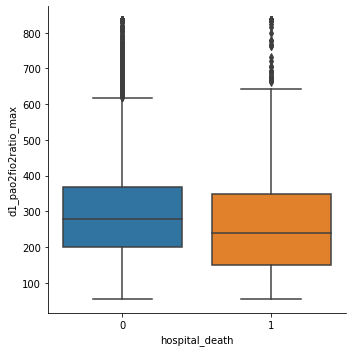

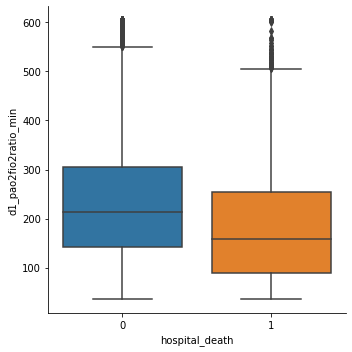

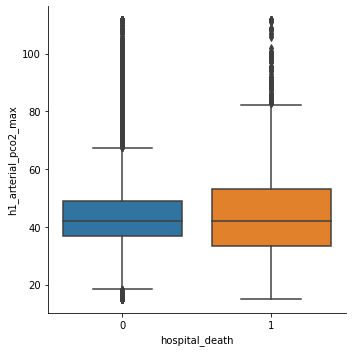

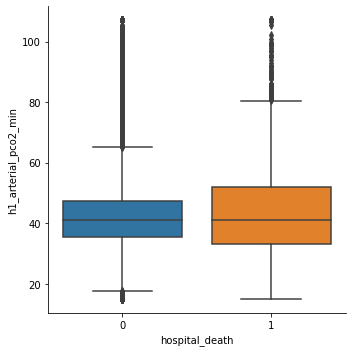

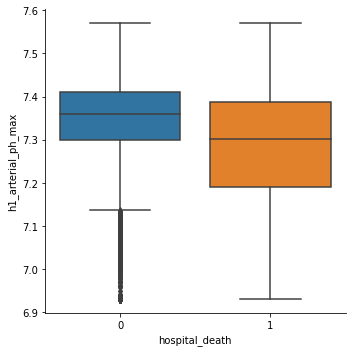

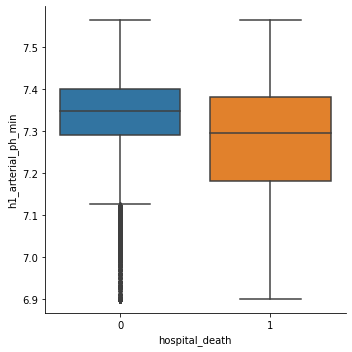

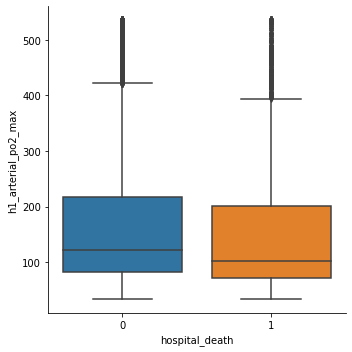

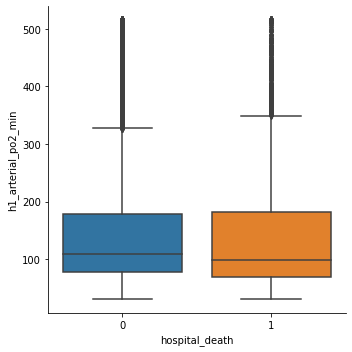

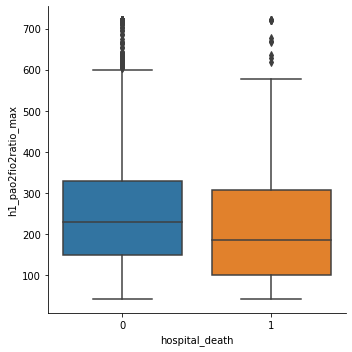

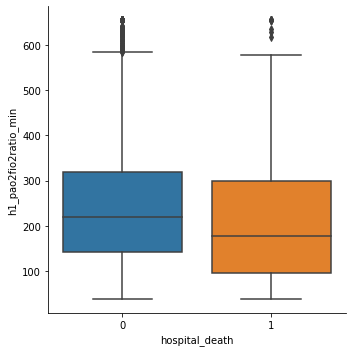

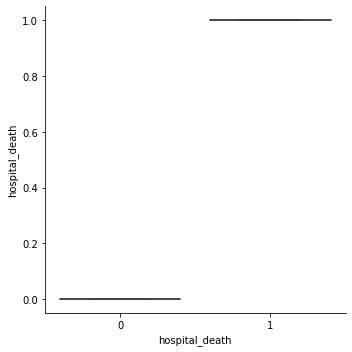

In [68]:
df_d1_h1['hospital_death'] = df.hospital_death.copy()
for col in df_d1_h1.columns:
    sns.catplot(x="hospital_death", y=col, data = df_d1_h1, kind = "box")

In [40]:
df_d1_h1 = df[df.columns[df.columns.str.contains("|".join(['d1','h1']))]]
df_d1_h1_corr = df_d1_h1.corr().abs().unstack().drop_duplicates().sort_values(ascending = False)
df_d1_h1_corr

d1_diasbp_invasive_max  d1_diasbp_invasive_max      1.000000
h1_bilirubin_max        h1_bilirubin_min            0.999934
h1_albumin_max          h1_albumin_min              0.999727
h1_bun_max              h1_bun_min                  0.999630
h1_creatinine_max       h1_creatinine_min           0.999405
                                                      ...   
h1_spo2_min             h1_sysbp_noninvasive_max    0.000089
d1_sysbp_invasive_min   d1_sodium_min               0.000030
h1_albumin_max          h1_arterial_po2_min         0.000020
h1_diasbp_invasive_max  d1_arterial_pco2_min        0.000019
d1_mbp_invasive_max     d1_arterial_po2_min         0.000008
Length: 7876, dtype: float64

In [62]:
df_d1_h1_corr[df_d1_h1_corr>0.99]

15

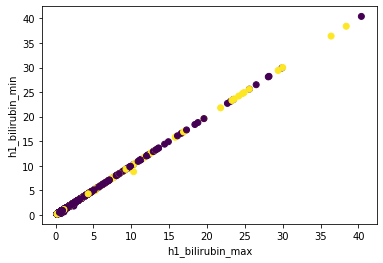

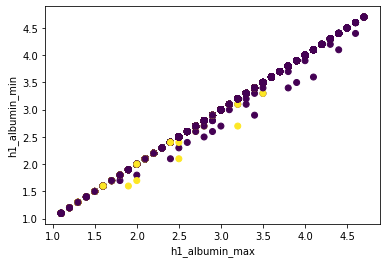

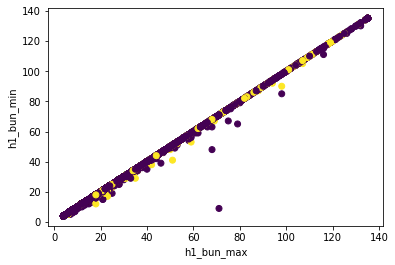

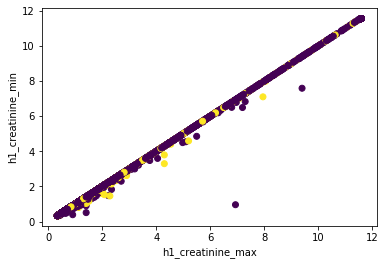

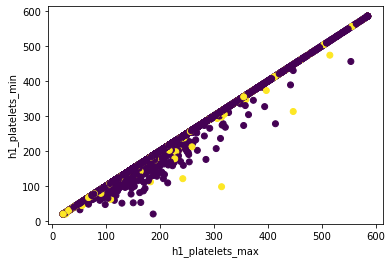

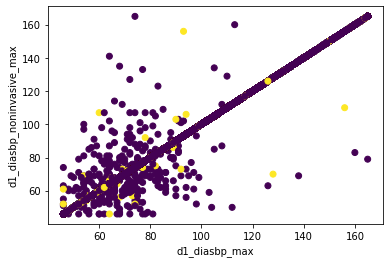

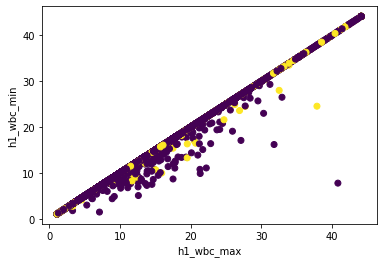

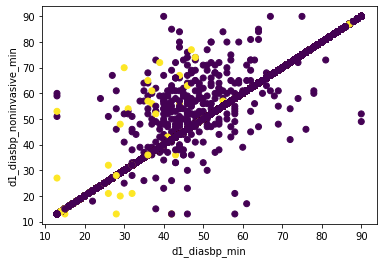

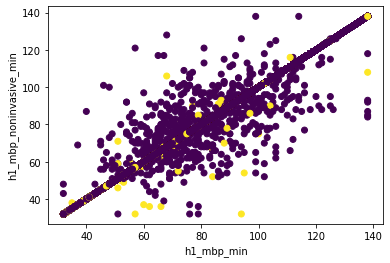

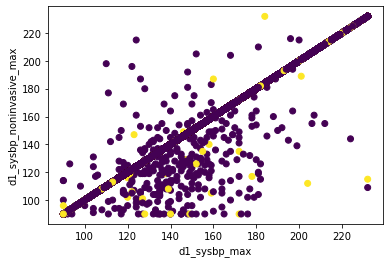

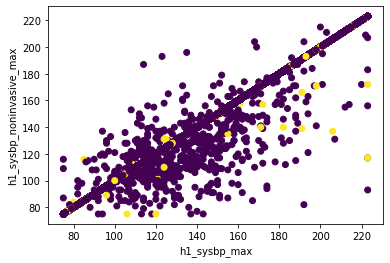

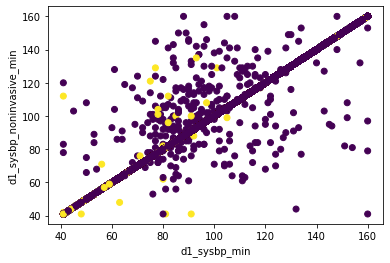

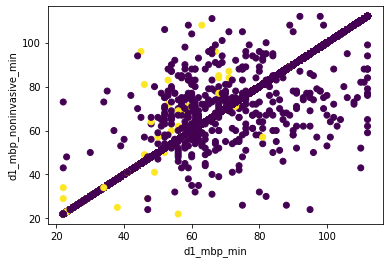

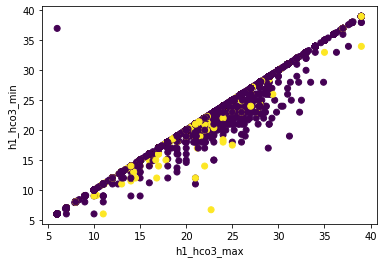

In [78]:
for i in range(1, 15):
    #print(df[df_d1_h1_corr.index[i][0]],df[df_d1_h1_corr.index[i][1]] )
    #sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter,df[df_d1_h1_corr.index[i][0]], df[df_d1_h1_corr.index[i][1]])
    plt.scatter(df[df_d1_h1_corr.index[i][0]],df[df_d1_h1_corr.index[i][1]], c = df.hospital_death)
    plt.xlabel(df_d1_h1_corr.index[i][0])
    plt.ylabel(df_d1_h1_corr.index[i][1])
    plt.show()
    #plt.legend()
#for i in df_d1_h1_corr.index[1][0]

Inference from the scatter plot of vitals and labs taken at 1st hour and after 24 hoiurs

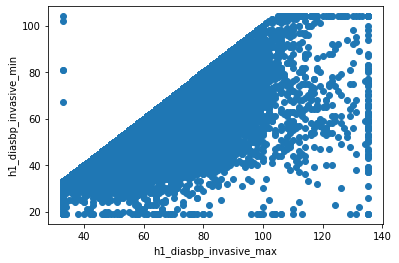

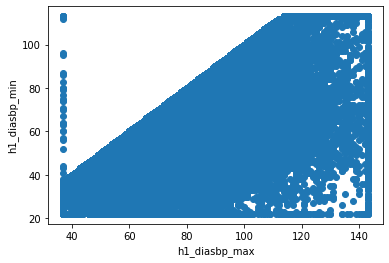

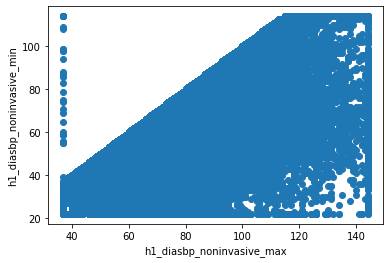

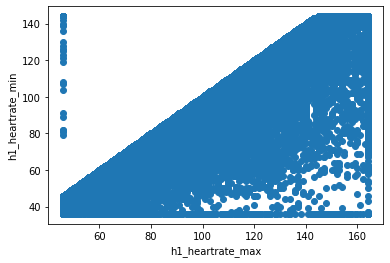

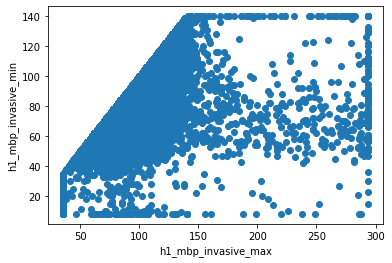

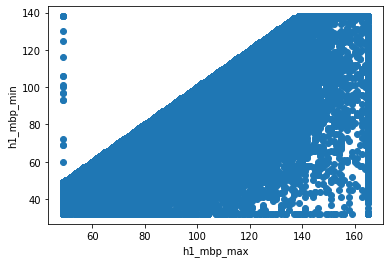

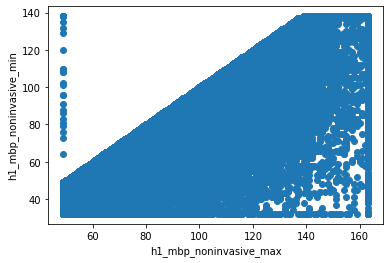

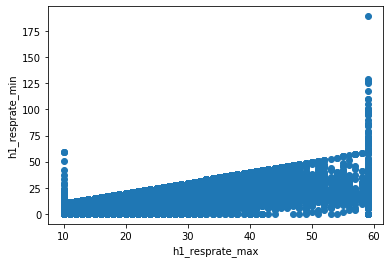

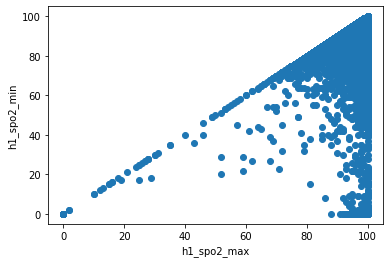

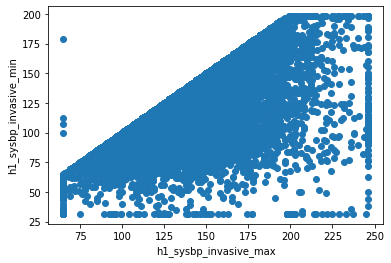

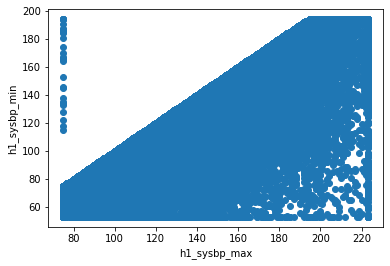

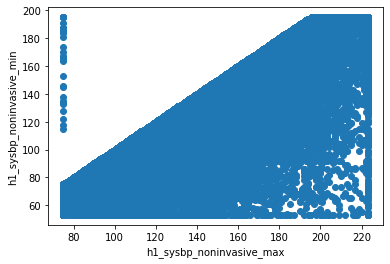

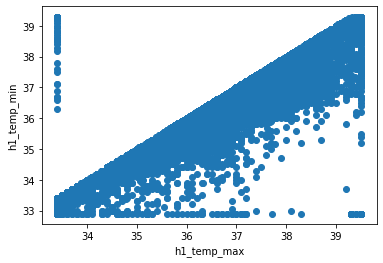

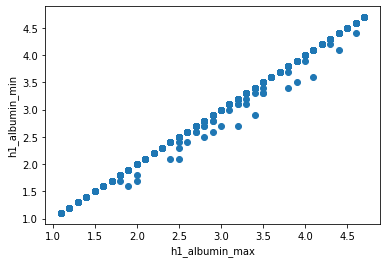

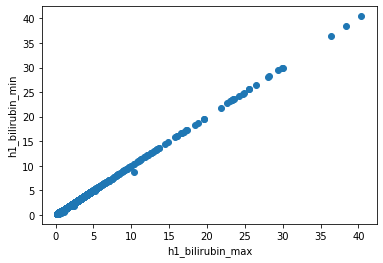

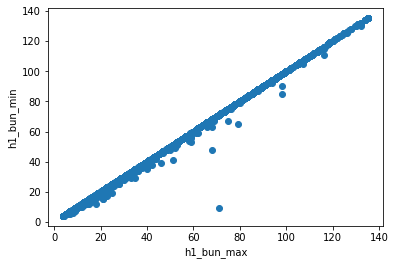

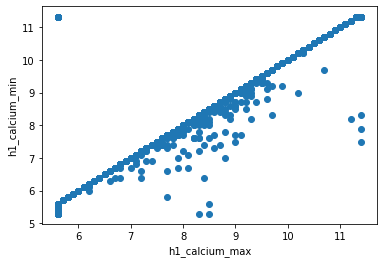

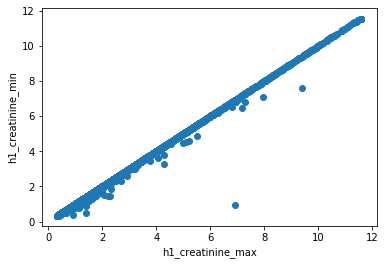

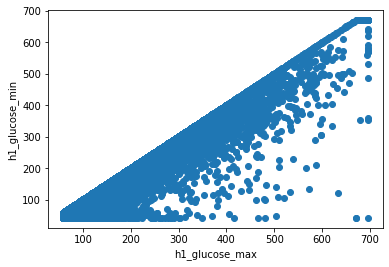

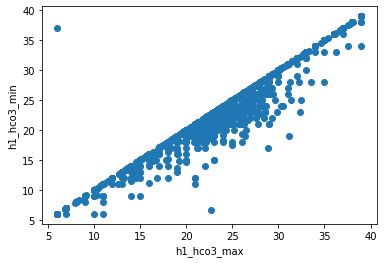

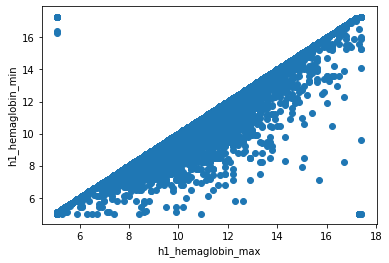

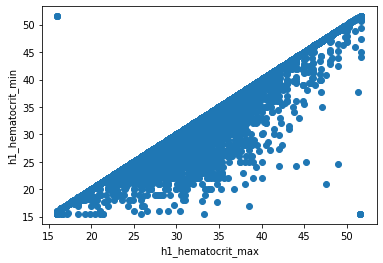

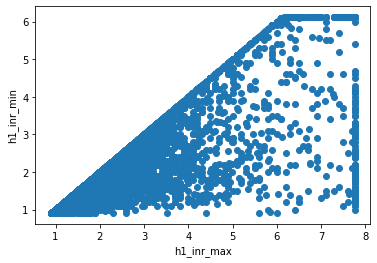

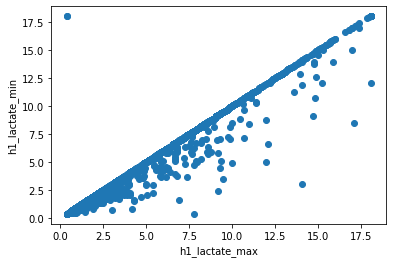

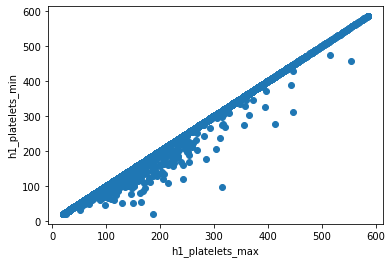

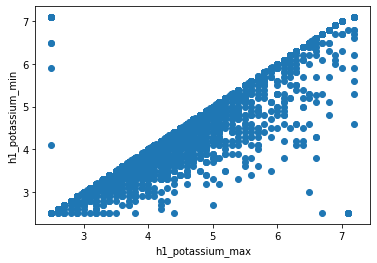

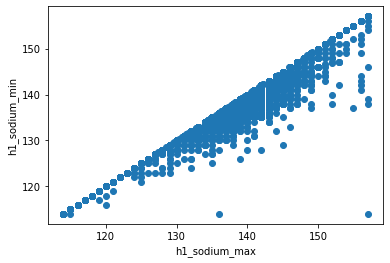

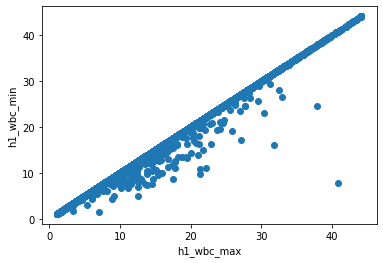

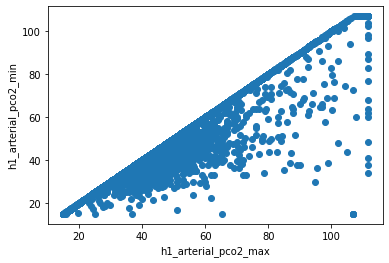

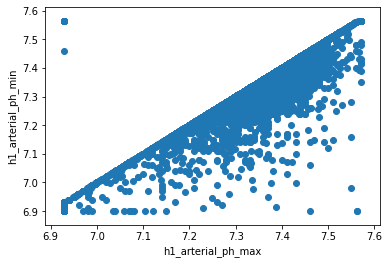

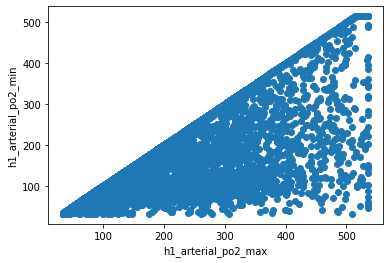

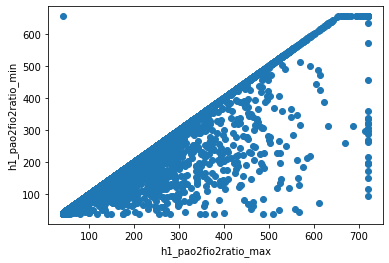

In [103]:
for i in range(0,64,2):
    plt.scatter(df[h1_features[i]], df[h1_features[i+1]])
    plt.xlabel(h1_features[i])
    plt.ylabel(h1_features[i+1])
    plt.show()

    
#list(range(0,10,2))
    #print(h1_features[i], h1_features[i+1]
    #plt.scatter(df.i)

A linear slope is observed between min and max for all the first hour vitals and labs parameters.
Inference: For some (majority) patients, the max and min are the same, while for others it is different
    

In [106]:
df_d1_h1[df_d1_h1.columns[df_d1_h1.columns.str.contains("diasbp")]].corr()

,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min
d1_diasbp_invasive_max,1.000000,0.278430,0.311222,0.180036,0.285483,0.171015,0.561046,0.374181,0.313901,0.252085,0.275387,0.234761
d1_diasbp_invasive_min,0.278430,1.000000,0.211949,0.478301,0.208069,0.454189,0.460199,0.662096,0.312112,0.458109,0.288350,0.423343
d1_diasbp_max,0.311222,0.211949,1.000000,0.131728,0.997831,0.126237,0.387027,0.335841,0.608853,0.357594,0.607833,0.345112
d1_diasbp_min,0.180036,0.478301,0.131728,1.000000,0.128525,0.996871,0.292660,0.391220,0.350422,0.617253,0.354839,0.629378
d1_diasbp_noninvasive_max,0.285483,0.208069,0.997831,0.128525,1.000000,0.126345,0.372301,0.329343,0.607342,0.354925,0.608470,0.345387
d1_diasbp_noninvasive_min,0.171015,0.454189,0.126237,0.996871,0.126345,1.000000,0.279823,0.371562,0.346839,0.614469,0.354446,0.629521
h1_diasbp_invasive_max,0.561046,0.460199,0.387027,0.292660,0.372301,0.279823,1.000000,0.675538,0.644402,0.526250,0.554295,0.482953
h1_diasbp_invasive_min,0.374181,0.662096,0.335841,0.391220,0.329343,0.371562,0.675538,1.000000,0.539746,0.689405,0.500388,0.604130
h1_diasbp_max,0.313901,0.312112,0.608853,0.350422,0.607342,0.346839,0.644402,0.539746,1.000000,0.630903,0.984292,0.622800
h1_diasbp_min,0.252085,0.458109,0.357594,0.617253,0.354925,0.614469,0.526250,0.689405,0.630903,1.000000,0.621907,0.981733


Observations:

- d1_diasbp_noninvasive_max and d1_diasbp_max are strongly correlated
- d1_diasbp_noninvasive_min and d1_diasbp_min are strongly correlated
- h1_diasbp_noninvasive_max and h1_diasbp_max are strongly correlated
- h1_diasbp_noninvasive_min and h1_diasbp_min are strongly correlated

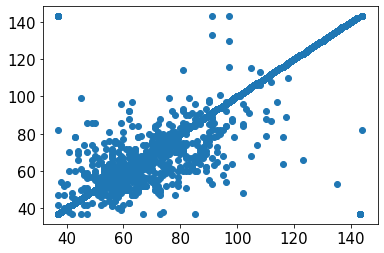

In [105]:
plt.scatter(df.h1_diasbp_noninvasive_max, df.h1_diasbp_max)

In [69]:
df_d1_h1_corr = df_d1_h1.corr()
df_d1_h1_corr['hospital_death'].sort_values(ascending=False)


hospital_death           1.000000
d1_lactate_min           0.403614
d1_lactate_max           0.399029
h1_lactate_min           0.344046
h1_lactate_max           0.340951
                           ...   
d1_mbp_invasive_min     -0.222350
h1_albumin_max          -0.224928
h1_albumin_min          -0.225402
d1_arterial_ph_min      -0.230365
d1_sysbp_invasive_min   -0.234382
Name: hospital_death, Length: 129, dtype: float64

- None of the h1 or d1 features have strong correlation with output

Understanding apache co-variate features

In [70]:
df_apache = df[apache_features].copy()
df_apache.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 32 columns):
albumin_apache                   37334 non-null float64
apache_2_diagnosis               90051 non-null float64
apache_3j_diagnosis              90612 non-null float64
apache_post_operative            91713 non-null int64
arf_apache                       90998 non-null float64
bilirubin_apache                 33579 non-null float64
bun_apache                       72451 non-null float64
creatinine_apache                72860 non-null float64
fio2_apache                      20845 non-null float64
gcs_eyes_apache                  89812 non-null float64
gcs_motor_apache                 89812 non-null float64
gcs_unable_apache                90676 non-null float64
gcs_verbal_apache                89812 non-null float64
glucose_apache                   80677 non-null float64
heart_rate_apache                90835 non-null float64
hematocrit_apache                71835 non-null float

- There are equal number of missing values in gcs_eyes_apache, gcs_motor_apache, gcs_unable_apache and gcs_verbal_apache
- GCS - Glasgow Coma Scale: "The Glasgow Coma Scale is a neurological scale which aims to give a reliable and objective way of recording the state of a person's consciousness for initial as well as subsequent assessment. source: wikipedia
- gcs_unable_apache: Not able to measure gcs because patient was sedated -- 864 observations. We can drop this feature. Since we have to impute missing values for all gcs features, we can drop this varable.
- gcs features (eye, verbal and motor) can be combined into one feature: gcs score. 

In [71]:
#df_apache[df_apache.columns[df_apache.columns.str.startswith("gcs")]].describe()
df_apache[df_apache.gcs_unable_apache == 1][['gcs_eyes_apache', 'gcs_motor_apache','gcs_verbal_apache','gcs_unable_apache']]

,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,gcs_unable_apache
128,NaN,NaN,NaN,1.0
776,NaN,NaN,NaN,1.0
8380,NaN,NaN,NaN,1.0
9707,NaN,NaN,NaN,1.0
10577,NaN,NaN,NaN,1.0
...,...,...,...,...
82674,NaN,NaN,NaN,1.0
83686,NaN,NaN,NaN,1.0
85159,NaN,NaN,NaN,1.0
87415,NaN,NaN,NaN,1.0


In [72]:
df_apache['gcs_score_apache'] = df_apache['gcs_eyes_apache'] + df_apache['gcs_verbal_apache'] + df_apache['gcs_motor_apache']
df_apache['hospital_death'] = df.hospital_death.copy()
df_apache.groupby('gcs_score_apache')['hospital_death'].sum()

gcs_score_apache
3.0     1824
4.0      123
5.0      114
6.0      359
7.0      440
8.0      359
9.0      308
10.0     308
11.0     258
12.0     251
13.0     386
14.0     775
15.0    2081
Name: hospital_death, dtype: int64

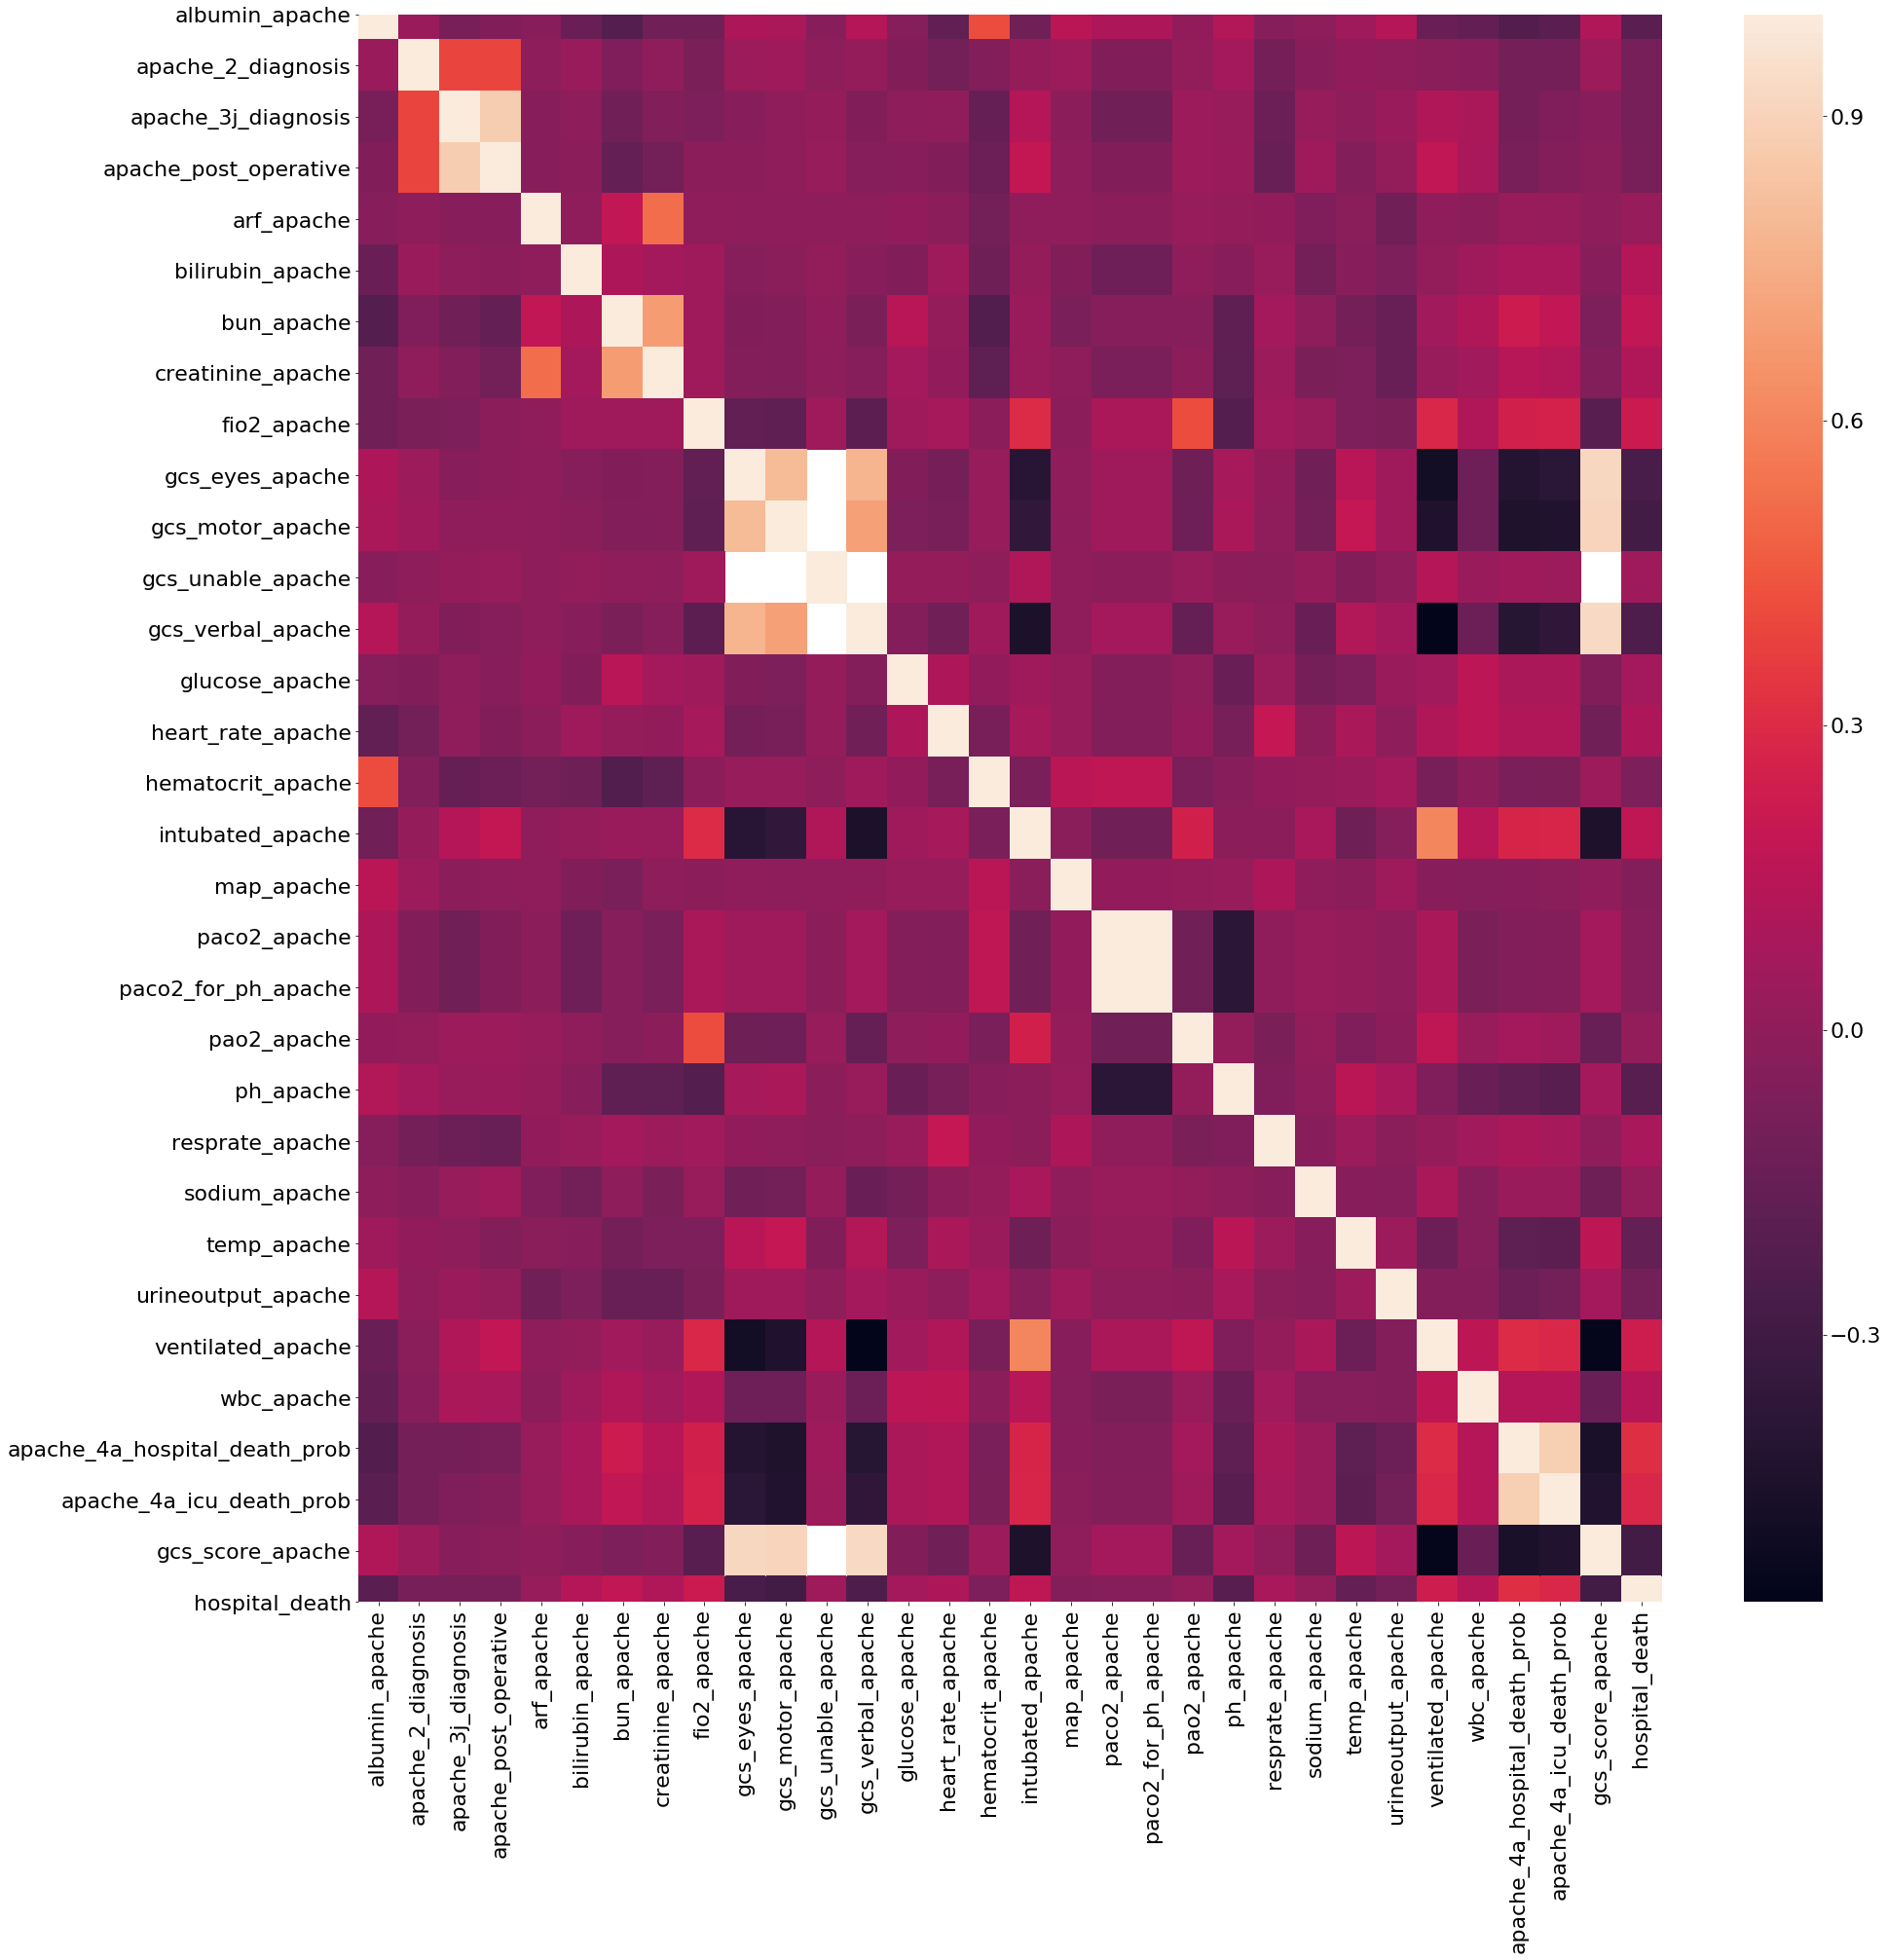

In [73]:
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 22})
sns.heatmap(df_apache.corr())

In [114]:
drop_features.append('paco2_for_ph_apache')
drop_features

['patient_id', 'encounter_id', 'paco2_for_ph_apache']

In [74]:
df_apache.corr()['hospital_death'].sort_values(ascending=False)

hospital_death                   1.000000
apache_4a_hospital_death_prob    0.311043
apache_4a_icu_death_prob         0.283913
ventilated_apache                0.228661
fio2_apache                      0.212249
bun_apache                       0.181435
intubated_apache                 0.173139
bilirubin_apache                 0.137464
wbc_apache                       0.134265
creatinine_apache                0.114699
heart_rate_apache                0.107818
resprate_apache                  0.086666
glucose_apache                   0.066430
gcs_unable_apache                0.051774
arf_apache                       0.027309
sodium_apache                    0.013216
pao2_apache                      0.012445
paco2_for_ph_apache             -0.035241
paco2_apache                    -0.035241
map_apache                      -0.040526
hematocrit_apache               -0.062600
apache_post_operative           -0.083674
apache_2_diagnosis              -0.089862
apache_3j_diagnosis             -0

- paco2_apache is exacty the same as paco2_for_ph_apache. One of the features can be dropped
- if a patient is intubated, they are mechanically ventillated (intubated =1; then ventilated = 1)
- Try imputing 0.21 for fio2 
- None of the apache features have strong correlation with hospital death


In [75]:
df_apache[['intubated_apache','ventilated_apache']].groupby('intubated_apache')['ventilated_apache'].aggregate(['sum','count'])

,sum,count
intubated_apache,,
0.0,15879.0,77237
1.0,13761.0,13761


In [76]:
## fio2 is the fraction of oxygen in the ait provided to the patient
## missing value - impute 0.21 (21% air)
## check whether ventillated patients have fio2 values
df_apache[['intubated_apache','ventilated_apache','fio2_apache']].dropna()
df_apache[df_apache.intubated_apache == 1][['intubated_apache','fio2_apache']].isnull().any()

df_apache.query("intubated_apache == 0 and ventilated_apache == 1")['fio2_apache']

1        1.0
7        NaN
8        1.0
23       NaN
27       NaN
        ... 
91695    NaN
91696    NaN
91702    NaN
91708    NaN
91712    NaN
Name: fio2_apache, Length: 15879, dtype: float64

In [77]:
### 3.2 Understanding the APACHE 4 prediction values
df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob', 'hospital_death']].describe()#sort_values(by='hospital_death', ascending = False)
## some probabilistic prediction are negative??

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
count,83766.000000,83766.000000,91713.000000
mean,0.086787,0.043955,0.086302
std,0.247569,0.217341,0.280811
min,-1.000000,-1.000000,0.000000
25%,0.020000,0.010000,0.000000
50%,0.050000,0.020000,0.000000
75%,0.130000,0.060000,0.000000
max,0.990000,0.970000,1.000000


Some predictions are negative. One interpreation for negative probability could be that features underlying the APACHE probabilistic model may have missing values. Let us check:<br>
Here is the logic:<br>
if # observations with -1 == # observations with missing values in any one feature <br>
then <br>
probability prediction = -1

In [78]:
print("Hypothesis: Apache 4a in hospital death prediction is -1 for observation with missing values")
print("# observation with -1 prediction:", df[df.apache_4a_hospital_death_prob == -1].shape[0])
print("Number of observations with missing values in any one feature:", df[df.apache_4a_hospital_death_prob == -1].isnull().any(axis=1).sum()
     )
print("Hypothesis: Apache 4a in ICU death prediction is -1 for observation with missing values")
print("# observation with -1 prediction:", df[df.apache_4a_icu_death_prob == -1].shape[0])
print("Number of observations with missing values in any one feature:", df[df.apache_4a_icu_death_prob == -1].isnull().any(axis=1).sum())

Hypothesis: Apache 4a in hospital death prediction is -1 for observation with missing values
# observation with -1 prediction: 2371
Number of observations with missing values in any one feature: 2371
Hypothesis: Apache 4a in ICU death prediction is -1 for observation with missing values
# observation with -1 prediction: 2230
Number of observations with missing values in any one feature: 2230


For both in hospital and in ICU, the assumption is True <br>
    # observations with -1 == # observations with missing values in any one feature 

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
apache_4a_hospital_death_prob,1.000000,0.966818,0.482097
apache_4a_icu_death_prob,0.966818,1.000000,0.476328
hospital_death,0.482097,0.476328,1.000000


<Figure size 720x720 with 0 Axes>

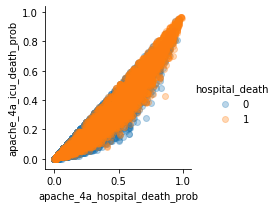

In [81]:
### dataframe with apache mortality prediction -1 and NAN removed
## Dropping negative values
## We know that there are 2371 rows with negative values for inhospital death
df_mort_pred = df[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob', 'hospital_death']].copy()
df_mort_pred.drop(df_mort_pred[df_mort_pred.apache_4a_hospital_death_prob == -1].index, inplace = True)
df_mort_pred.drop(df_mort_pred[df_mort_pred.apache_4a_icu_death_prob == -1].index, inplace = True)
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
sns.FacetGrid(df_mort_pred, hue = "hospital_death").map(plt.scatter, "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", alpha =0.3).add_legend()
df_mort_pred.corr()

In [82]:
df_mort_pred[df_mort_pred.apache_4a_icu_death_prob > 0.9].groupby('hospital_death').count()
df_mort_pred[df_mort_pred.apache_4a_icu_death_prob > 0.1].groupby('hospital_death').count()

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
hospital_death,,
0,9117,9117
1,4555,4555


- apache 4 predictions for in hospital mortality is linearly correlated with that of ICU mortality
- apache 4 ICU prediction is not true mortality prediction. As shown below ICU mortality 

    - prediction of > 0.9 --> All observations with > 0.9 should be dead. About 6% is incorrect
    - prediction of <0.1 --> All observations with <0.1 should have survived. About 33% is incorrect.



Understanding rest of the features

Is there any observation where height and weight are present but bmi is not present?


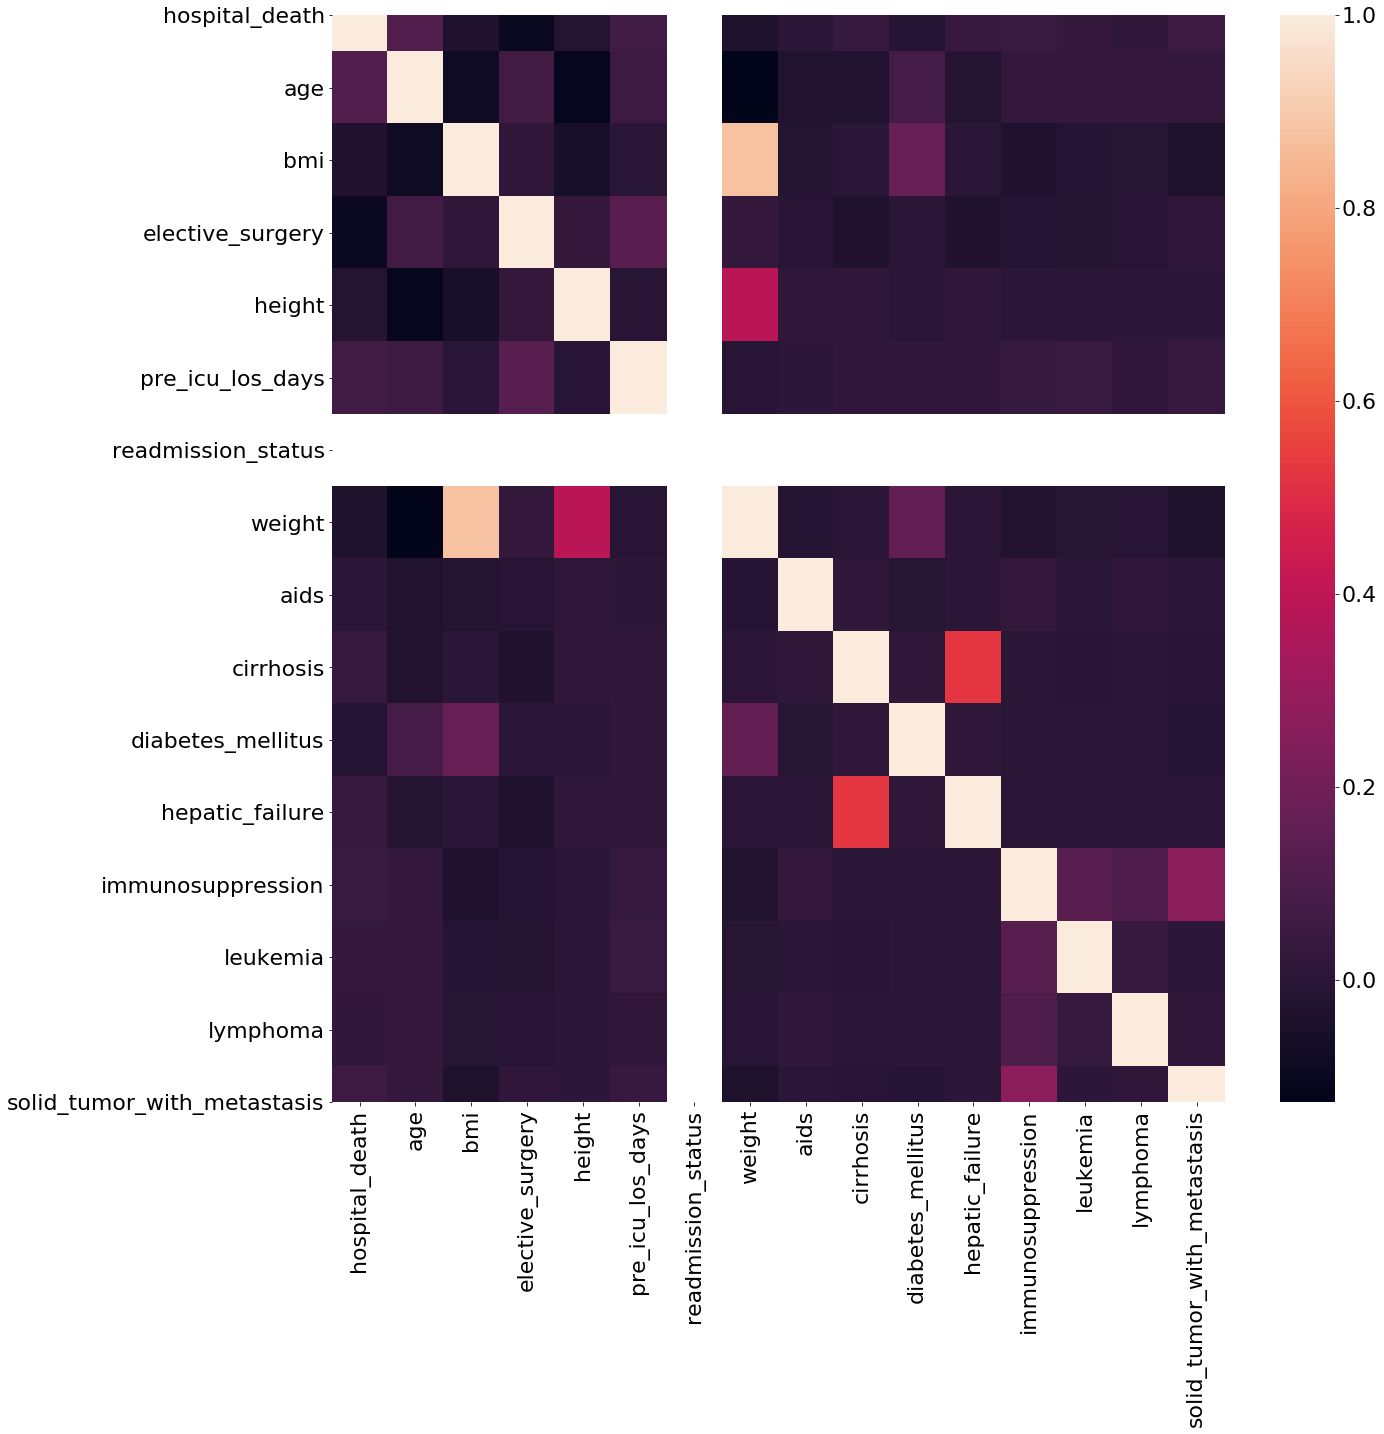

In [83]:
#bmi = (height/weight**2)*10000
print("Is there any observation where height and weight are present but bmi is not present?")
df[~df.height.isnull()&~df.weight.isnull()&df.bmi.isnull()][['height','weight','bmi']]
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 22})
df_rest_features = df[rest_features].copy()
df_rest_features['hospital_death'] = df.hospital_death
sns.heatmap(df_rest_features.corr())

In [84]:
df.groupby('cirrhosis')['hepatic_failure'].agg(['sum','count'])

,sum,count
cirrhosis,,
0.0,490.0,89570
1.0,692.0,1428


In [86]:
df_rest_features.select_dtypes(include='object').describe()

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
count,90318,91688,70304,91601,91713,91713
unique,6,2,15,5,3,8
top,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
freq,70684,49469,36962,54060,86183,50586


In [87]:
for col in df_rest_features.select_dtypes(include='object'):
    print("#"*25 + col + "#"*25)
    print(df_rest_features[col].value_counts())

#########################ethnicity#########################
Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64
#########################gender#########################
M    49469
F    42219
Name: gender, dtype: int64
#########################hospital_admit_source#########################
Emergency Department    36962
Operating Room           9787
Floor                    8055
Direct Admit             6441
Recovery Room            2896
Acute Care/Floor         1910
Other Hospital           1641
Step-Down Unit (SDU)     1131
PACU                     1017
Other ICU                 233
Chest Pain Center         134
ICU to SDU                 45
ICU                        35
Observation                10
Other                       7
Name: hospital_admit_source, dtype: int64
#########################icu_admit_source#########################
Accident & Emerge

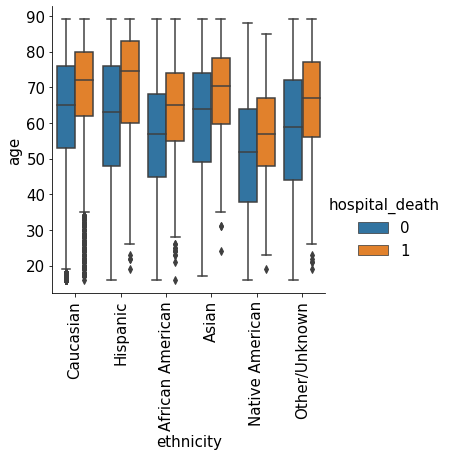

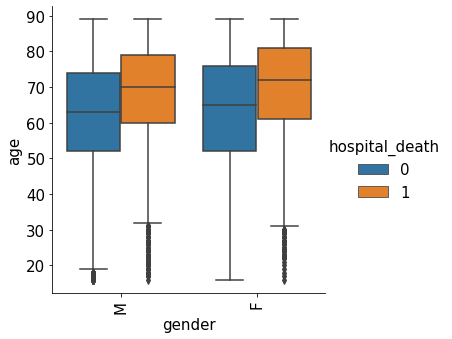

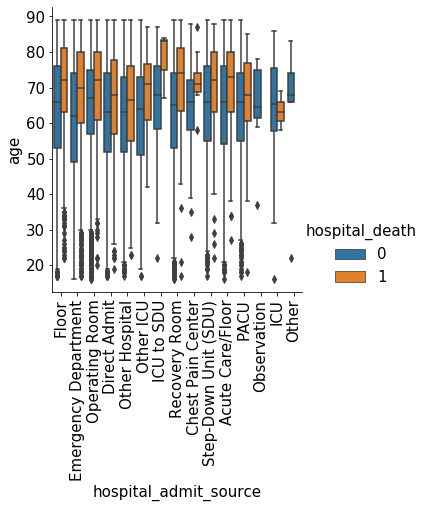

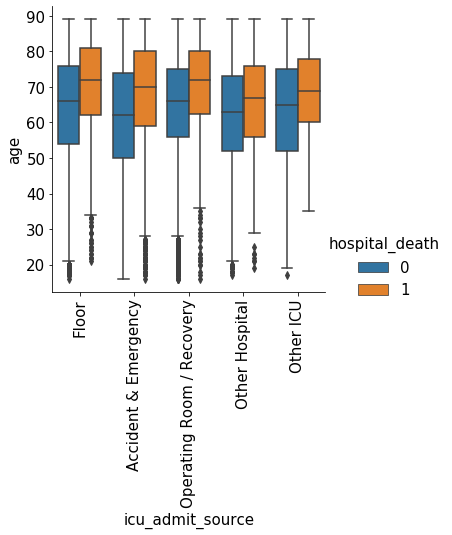

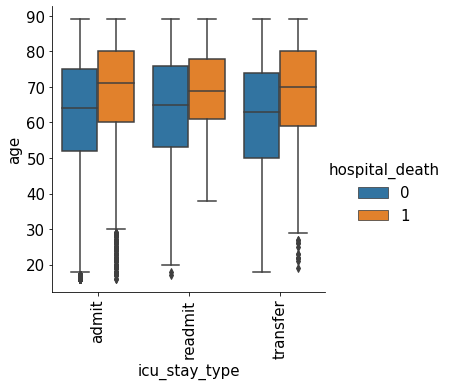

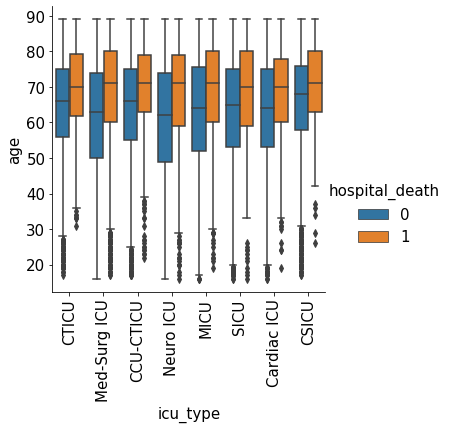

In [88]:
for col in df_rest_features.select_dtypes(include='object'):
    plt.rcParams.update({'font.size': 15})
    sns.catplot(x=col, y="age", hue = "hospital_death", data=df_rest_features, kind = "box")
    plt.xticks(rotation=90)
    plt.show()

(array([0, 1]), <a list of 2 Text xticklabel objects>)

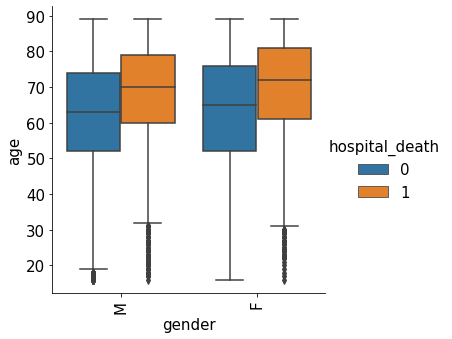

In [377]:
plt.rcParams.update({'font.size': 15})
sns.catplot(x="gender", y="age", hue = "hospital_death", data=df_rest_features, kind = "box")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

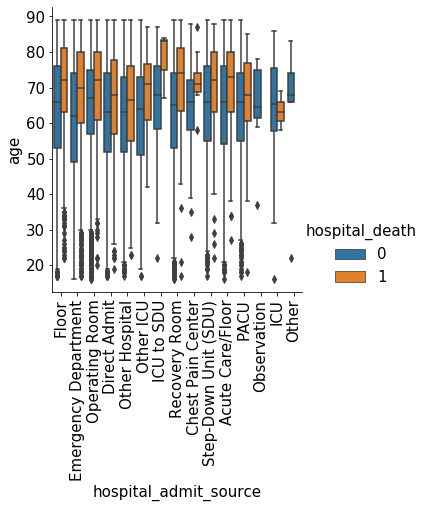

In [89]:
plt.rcParams.update({'font.size': 15})
sns.catplot(x="hospital_admit_source", y="age", hue = "hospital_death", data=df_rest_features, kind = "box")
plt.xticks(rotation=90)

- hospital_admit_source = observation --> No death
- Median age of patient dying in ICU is larger than non-dying patient

In [92]:
print(hospital_id_df[hospital_id_df['sum']==0].index)
df[df['hospital_admit_source'] == 'Observation'][['hospital_id', 'icu_id']]

Int64Index([4, 38, 43, 66, 72, 85, 93, 95, 111, 124], dtype='int64', name='hospital_id')


,hospital_id,icu_id
19374,161,413
19963,136,374
21259,112,384
28690,112,347
28841,136,374
30144,171,404
30853,171,404
65290,40,650
79544,196,829
85041,188,841


In [387]:
#df[df.hospital_admit_source == 'Observation'|df.hospital_admit_source == 'Other']#['hospital_death']
df.query("hospital_admit_source == 'Observation' or hospital_admit_source == 'Other'")[['hospital_admit_source','hospital_death']]

,hospital_admit_source,hospital_death
19374,Observation,0
19963,Observation,0
21259,Observation,0
28690,Observation,0
28841,Observation,0
30144,Observation,0
30853,Observation,0
62105,Other,0
63683,Other,0
64592,Other,0


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

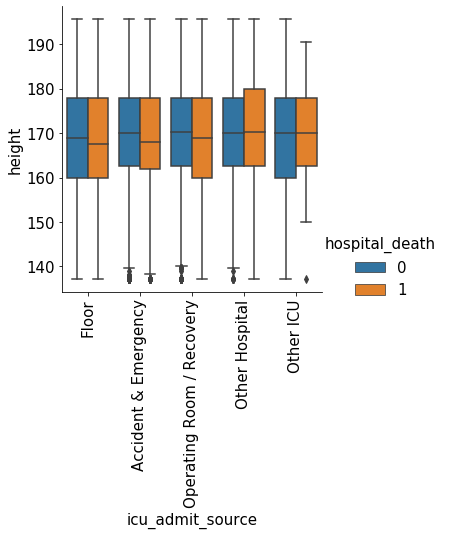

In [103]:
plt.rcParams.update({'font.size': 15})
sns.catplot(x="icu_admit_source", y="height", hue = "hospital_death", data=df_rest_features, kind = "box")
plt.xticks(rotation=90)

3.3 Understanging missing values

In [104]:
print("Number of features with missing values:", sum(df.isna().sum() > 0))
print("Features without missing values",df.columns[~df.isnull().any()])
print("Any observation with missing values for all features?",df.loc[:, df.columns != 'hospital_death'].isnull().all(axis = 1).any())
print("List of features with >90% data missing:", list(df.columns[df.isna().sum()/df.shape[0] > 0.9]))

Number of features with missing values: 175
Features without missing values Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death',
       'elective_surgery', 'icu_id', 'icu_stay_type', 'icu_type',
       'pre_icu_los_days', 'readmission_status', 'apache_post_operative'],
      dtype='object')
Any observation with missing values for all features? False
List of features with >90% data missing: ['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min']


- 175 features has missing values in it
- Target feature "hospital_death" does not have missing value
- These features has more than 90% of the data missing and thus, they will be removed from the dataset:'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min'

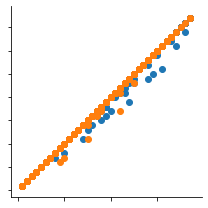

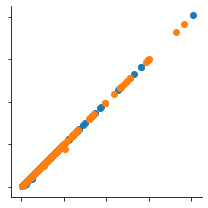

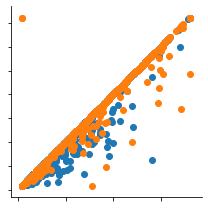

In [304]:
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_albumin_max", "h1_albumin_min")
plt.show()
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_bilirubin_max", "h1_bilirubin_min")
plt.show()
sns.FacetGrid(df, hue = "hospital_death").map(plt.scatter, "h1_lactate_max", "h1_lactate_min")
plt.show()

In [123]:
##########################################################
#3.2 Is this a imbalanced dataset?
##########################################################
df_feat_sel.hospital_death.value_counts(normalize = True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

This is a heavily imbalanced dataset with ~91% of the data belonging to "0" class or survived. To overcome this, we will use SMOTE technique to oversample the minority class. Before using SMOTE, we need to convert categorical variables to dummy variables

4. Data Cleaning and Feature Selection
        4.1 Feature Selection
            4.1.1 Dropping features with variance <0.01
            4.1.2 Dropping features with >90% of missing data
            4.1.3 Dropping highly correlated and insignificant features 

In [120]:
########################################################################
### 4.1.1 Dropping features with variance <0.01
########################################################################
#Split numeric and categorical variables as variance
df_numeric = df.select_dtypes(include = [float, int])
df_object = df.select_dtypes(include = [object])

###### Calculating variance for all numeric type feature and dropping fetaures with variance < 0.01
print("Columns with <0.01 variance dropped", df_numeric.columns[df_numeric.var() <=0.01].values)
#df_numeric.var().sort_values()[0:7]
df_feat_sel = df.drop(columns = df_numeric.columns[df_numeric.var() <0.01] )

###### Calculating variance for all object type feature and dropping features with single value
for f in df_object:
    if df_object[f].nunique() == 1:
        df_feat_sel.drop(columns = f, inplace = True)

Columns with <0.01 variance dropped ['readmission_status' 'gcs_unable_apache' 'ph_apache' 'd1_arterial_ph_max'
 'aids' 'leukemia' 'lymphoma']


* 7 numeric columns were dropped from the dataset as their variance is very small <.01. 
* All the object typed features in dataset have >1 unique values and thus they are not dropped

In [124]:
########################################################################
### 4.1.2 Dropping features with >90% of missing data
########################################################################
print("Number of features with missing values:", sum(df_feat_sel.isna().sum() > 0))

# - For class type 1 or type 0, does any of the feature has all missing values?
print("For class type 1 or type 0, does any of the feature has all missing values?")
print(df_feat_sel.set_index('hospital_death').isna().all(level=0).any().any())

# - List all the features that have >90% of the data missing 
feat_very_low_var = df_feat_sel.columns[df_feat_sel.isna().sum()/df_feat_sel.shape[0] > 0.9]
print("Following features have >90% of the data missing and they will be deleted:",
      list(feat_very_low_var))

df_feat_sel = df_feat_sel.drop(columns = feat_very_low_var)
df_feat_sel.shape

Number of features with missing values: 162
For class type 1 or type 0, does any of the feature has all missing values?
False
Following features have >90% of the data missing and they will be deleted: []


(91713, 170)

In [122]:
########################################################################
### 4.1.3 Dropping highly correlated and insignificant features
########################################################################
# From EDA we observed that paco2_apache is exacty the same as paco2_for_ph_apache
df_feat_sel = df_feat_sel.drop(columns = drop_features)
df_feat_sel.shape

(91713, 170)

- Out of 186 features, 175 features have missing values in them. 
- More than 90% of the data is missing for 6 features and they were dropped
- All together, 14 features were dropped from the dataset: readmission_status', 'gcs_unable_apache', 'ph_apache', 'd1_arterial_ph_max', 'aids', 'leukemia', 'lymphoma', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_lactate_max', 'h1_lactate_min', 'paco2_for_ph_apache'

In [11]:
corr_matrix = df_feat_sel.corr()

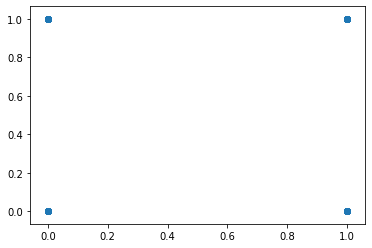

In [12]:
plt.scatter(df_feat_sel.cirrhosis, df_feat_sel.hepatic_failure)
#df_feat_sel[['cirrhosis', 'hepatic_failure']]

- Cirrhosis and hepatic_failure are strongly linearly correlated

5. Data split: Train and test datasets

In [125]:
##########################################################
### 5. Split the features and target variable
##########################################################
y = df_feat_sel['hospital_death']
X = df_feat_sel.drop(columns = ['hospital_death'])

##########################################################
## Split features and variables to train and test data set
##########################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
print(X_train.shape)
print(X_test.shape)

(73370, 169)
(18343, 169)


In [126]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [127]:
#Building pipeline for input transformation

num_attributes = X_train.select_dtypes(exclude = 'object').columns
obj_attributes = X_train.select_dtypes(include = 'object').columns

pipeline_num = Pipeline([('attributes',DataFrameSelector(num_attributes)),
                          ('standardization', StandardScaler()), 
                         ('imputer', SimpleImputer(strategy = 'median'))])
pipeline_obj = Pipeline([('attributes',DataFrameSelector(obj_attributes)),
                         ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'other')),
                        ('onehotencode', OneHotEncoder(handle_unknown='ignore'))])

pipeline_full = FeatureUnion(transformer_list=[("numerical_features", pipeline_num),
                                               ("categorical_features", pipeline_obj)])



In [128]:
x_train = pipeline_full.fit_transform(X_train)
x_test = pipeline_full.transform(X_test)

In [129]:
############################################################################
## Oversampling datapoints with minority class to make it a balanced dataset
############################################################################
sm = SMOTE()
X_train_os, y_train_os = sm.fit_resample(x_train, y_train)
print("After oversampling, x_train shape is {} and y_train shape is {}".format(X_train_os.shape, 
                                                                               y_train_os.shape))

After oversampling, x_train shape is (134076, 227) and y_train shape is (134076,)


In [130]:
### Defininig functions for calculating Precision, Recall, F1-score and AUC for ROC and PRcurve

### Run all models with default parameter and downselect one and fine tune it later
def evaluate_model(model, train_data_x, train_data_y):
    '''Returns the CV score of each model'''
    return cross_val_score(model, train_data_x, train_data_y, scoring = 'roc_auc', cv = 5)

def classification_metrics(model, test_data_x, test_data_y):
    '''Returns metric for classification model in the form of tuple: (precision, recall, auc P-R, auc - ROC, confusion matrix)'''
    predicted_test_data_y = model.predict(test_data_x)
    predicted_test_data_y_prob = model.predict_proba(test_data_x)
    precision = precision_score(test_data_y, predicted_test_data_y)
    recall = recall_score(test_data_y, predicted_test_data_y)
    precision_l, recall_l, threshold = precision_recall_curve(test_data_y, predicted_test_data_y_prob[:,1])
    auc_pr = auc(recall_l, precision_l)
    auc_roc = roc_auc_score(test_data_y, predicted_test_data_y_prob[:,1])
    cm = confusion_matrix(test_data_y, predicted_test_data_y)     
    ll = log_loss(test_data_y, predicted_test_data_y)
    return (precision, recall, auc_pr, auc_roc, cm, ll)
#def custom_pr_auc(y_true, y_pred):
#    p, r, thrshld = precision_recall_curve(test_data_y, predicted_test_data_y_prob[:,1])
#    auc_pr = auc(r, p)
#    return auc_pr

#pr_auc = make_scorer(auc(precision_recall_curve()[1],auc(precision_recall_curve()[0]),
#                     greater_is_better=True, needs_proba=False, needs_threshold=False, **kwargs)

scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 
          'roc':'roc_auc'}


In [20]:
#### Modelling: KNN
## Logistic regression with balanced data - oversampling and unweighted model
#knn_os = knn()
#knn_os.fit(X_train_os, y_train_os)
#knn_os.score(x_test, y_test)
#knn_os_cv = cross_val_score(knn_os, X_train_os, y_train_os, scoring = "f1", cv = 2)
#print("Averge CV score for KNN is {%3f} +- {%3f}".format(lr_os_cv.mean(), lr_os_cv.std()))

# Test data and metrics
#knn_os.fit(X_train_os, y_train_os)
#classification_metrics(lr_os,x_test, y_test)

In [131]:
#### Modelling: DummyClassifier for reference
dummy = DummyClassifier(random_state=42)
dummy_os = cross_validate(dummy, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
dummy.fit(X_train_os, y_train_os)
print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(dummy,x_test, y_test)))
#classification_metrics(dummy,x_test, y_test)

Precision: 0.0843556617088264 
 Recall: 0.490840176879343 
 P-R AUC: 0.3095681531707679 
 ROC-AUC:  0.4938091099193851 
 Confusion Matrix:  [[8326 8434]
 [ 806  777]] 



Dummy classifier's metrics are as shown above. If any of our model's ROC-AUC is similar to 0.5, then it is a no-skill classifier

In [132]:
alpha = [10 ** x for x in range(-5, 2)]

In [136]:
#### Modelling: Logistic Regression with regularization via SGD
#roc_metric = []
log_loss_metric = []

for i in alpha:
    sgd = SGDClassifier(alpha = i, loss = 'log', random_state=42)
    sgd_os = cross_validate(sgd, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
    sgd.fit(X_train_os, y_train_os)
    sgd_cal = CalibratedClassifierCV(sgd)
    sgd_cal.fit(X_train_os, y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
    log_loss_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-1])
    print("Alpha: ", i, "Log loss: ", classification_metrics(sgd_cal,x_test, y_test))
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

Alpha:  1e-05 Log loss:  (0.24731626754748143, 0.7567909033480733, 0.4363234167823477, 0.8484483104344037, array([[13114,  3646],
       [  385,  1198]]), 7.590291826861226)
Alpha:  0.0001 Log loss:  (0.2653370908302623, 0.7732154137713203, 0.4777081096135162, 0.8665694347911959, array([[13371,  3389],
       [  359,  1224]]), 7.0574084808273545)
Alpha:  0.001 Log loss:  (0.2669426890390063, 0.7738471257106759, 0.49490037100385675, 0.870629126292635, array([[13396,  3364],
       [  358,  1225]]), 7.008450939737924)
Alpha:  0.01 Log loss:  (0.27268722466960355, 0.7820593809222994, 0.49631443862689645, 0.875310466064706, array([[13458,  3302],
       [  345,  1238]]), 6.8672277044623975)
Alpha:  0.1 Log loss:  (0.2692055154300722, 0.7770056854074542, 0.48333908349147786, 0.8724682900206099, array([[13421,  3339],
       [  353,  1230]]), 6.95196163690943)
Alpha:  1 Log loss:  (0.25451490970180596, 0.7656348704990524, 0.4552350929009882, 0.8595734512126909, array([[13210,  3550],
       

In [138]:
sgd_cal.predict_proba(x_test)

array([[0.8615165 , 0.1384835 ],
       [0.55124874, 0.44875126],
       [0.43166029, 0.56833971],
       ...,
       [0.6237558 , 0.3762442 ],
       [0.82948277, 0.17051723],
       [0.33029604, 0.66970396]])

In [134]:
#### Modelling: Multinomial Naive Bayes
#roc_metric = []
#ls = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
#log_loss_metric_nb = []
#for i in ls:
nb = GaussianNB()
nb_os = cross_validate(nb, X_train_os.toarray(), y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
print("-"*10 + "Cross-Validate results" + "-"*10)
print(nb_os)
nb.fit(X_train_os.toarray(), y_train_os)
nb_cal = CalibratedClassifierCV(nb)
nb_cal.fit(X_train_os.toarray(), y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
#    log_loss_metric_nb.append(classification_metrics(nb_cal,x_test, y_test)[-1])
print("Log loss: ", classification_metrics(nb_cal,x_test.toarray(), y_test)[-1])
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

----------Cross-Validate results----------
{'fit_time': array([0.465276  , 0.43983722, 0.43284607]), 'score_time': array([0.47356105, 0.44723082, 0.44215202]), 'test_acc': array([0.73326322, 0.74668845, 0.74326501]), 'train_acc': array([0.73966258, 0.74601718, 0.74441735]), 'test_prec': array([0.6916149 , 0.73941368, 0.71029014]), 'train_prec': array([0.69635917, 0.73572164, 0.7113067 ]), 'test_rec': array([0.84194039, 0.76188132, 0.82166831]), 'train_rec': array([0.8499284 , 0.76785554, 0.8227647 ]), 'test_roc': array([0.81083711, 0.81191894, 0.81081737]), 'train_roc': array([0.81467915, 0.81240982, 0.81160584])}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log loss:  10.652028386948396


In [28]:
#### Modelling: Logistic Regression
## Logistic regression with balanced data - oversampling and unweighted model
lr_os = LogisticRegression(penalty = 'l1', C = 0.8)
lr_os_cv = cross_validate(lr_os, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
# = cross_val_score(lr_os, X_train_os, y_train_os, scoring = "f1", cv = 3)
#print("Averge CV score for Logistic Regression is {} +- {}".format(lr_os_cv.mean(), lr_os_cv.std()))

# Test data and metrics
lr_os.fit(X_train_os, y_train_os)
classification_metrics(lr_os,x_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.26956894702980916,
 0.7940619077700568,
 0.5083974964846747,
 0.8788855938016847,
 array([[13354,  3406],
        [  326,  1257]]))

In [134]:
#### Modelling: SVM
#roc_metric = []
log_loss_metric_svm = []

for i in alpha:
    svm = LinearSVC(C = i, loss = 'hinge')
    svm_os = cross_validate(sgd, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
    svm.fit(X_train_os, y_train_os)
    svm_cal = CalibratedClassifierCV(svm)
    svm_cal.fit(X_train_os, y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
    log_loss_metric.append(classification_metrics(svm_cal,x_test, y_test)[-1])
    print("Alpha: ", i, "Log loss: ", classification_metrics(svm_cal,x_test, y_test))
    #print("Precision: {0[0]} \n Recall: {0[1]} \n P-R AUC: {0[2]} \n ROC-AUC:  {0[3]} \n Confusion Matrix:  {0[4]} \n".format(classification_metrics(sgd,x_test, y_test)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1e-05 Log loss:  (0.2599407783417936, 0.7763739734680986, 0.4548092804374101, 0.8641979142952341, array([[13261,  3499],
       [  354,  1229]]), 7.255122021534052)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.0001 Log loss:  (0.27164835164835166, 0.7807959570435882, 0.4830895533834537, 0.8735436325999546, array([[13446,  3314],
       [  347,  1236]]), 6.893589393646169)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.001 Log loss:  (0.2736141906873614, 0.7795325331648768, 0.4923135862754947, 0.8751080619409388, array([[13484,  3276],
       [  349,  1234]]), 6.8258018815206105)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  0.01 Log loss:  (0.2709847984137475, 0.7770056854074542, 0.4916284306579416, 0.8737991442489336, array([[13451,  3309],
       [  353,  1230]]), 6.895472116123831)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  0.1 Log loss:  (0.26978891820580475, 0.7751105495893872, 0.49041620293863875, 0.8729128629516778, array([[13439,  3321],
       [  356,  1227]]), 6.923716745742368)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  1 Log loss:  (0.27100330760749725, 0.7763739734680986, 0.49009457350711805, 0.873111234069627, array([[13454,  3306],
       [  354,  1229]]), 6.891706104480038)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the numb

Alpha:  10 Log loss:  (0.2612165660051769, 0.7650031585596968, 0.4611696397374816, 0.8605943293676698, array([[13335,  3425],
       [  372,  1211]]), 7.149674131422029)


In [27]:
lr_os_cv

{'fit_time': array([66.63778806, 29.57610178, 32.0850749 ]),
 'score_time': array([0.08176494, 0.08106899, 0.08009696]),
 'test_acc': array([0.79933769, 0.79739103, 0.79965094]),
 'train_acc': array([0.80093753, 0.80047883, 0.80041171]),
 'test_prec': array([0.8017957 , 0.80183495, 0.80059257]),
 'train_prec': array([0.80205269, 0.80346651, 0.80331646]),
 'test_rec': array([0.79526537, 0.79002954, 0.79808467]),
 'train_rec': array([0.79909156, 0.79555625, 0.79562338]),
 'test_roc': array([0.88411199, 0.88299316, 0.88547396]),
 'train_roc': array([0.88555102, 0.88634215, 0.88500154])}

In [135]:
#### Modelling: Random Forest
## Randomforest
rf_os = RandomForestClassifier(n_estimators = 300, n_jobs = -1, random_state = 0)
rf_os_cv = cross_validate(rf_os, X_train_os, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)

print("Train and val CV score for Random Forest is:",rf_os_cv)

# Test data and metrics
rf_os.fit(X_train_os, y_train_os)
classification_metrics(rf_os,x_test, y_test)

Train and val CV score for Random Forest is: {'fit_time': array([ 234.32583618,  284.14959598, 1535.27754903]), 'score_time': array([4.8300817 , 5.02040291, 5.05111504]), 'test_acc': array([0.92190996, 0.97749038, 0.97518572]), 'train_acc': array([1., 1., 1.]), 'test_prec': array([0.98413269, 0.95888526, 0.95571006]), 'train_prec': array([1., 1., 1.]), 'test_rec': array([0.8576479 , 0.99776246, 0.99655419]), 'train_rec': array([1., 1., 1.]), 'test_roc': array([0.98863896, 0.99903384, 0.99879643]), 'train_roc': array([1., 1., 1.])}


KeyboardInterrupt: 

In [35]:
for i in lr_os_cv.keys():
    print(i, lr_os_cv[i].mean())

fit_time 42.76632157961527
score_time 0.08097696304321289
test_acc 0.7987932217548256
train_acc 0.8006093558877055
test_prec 0.801407738820166
train_prec 0.8029452206563928
test_rec 0.7944598585876667
train_rec 0.7967570631582088
test_roc 0.8841930334815707
train_roc 0.8856315708263232


([<matplotlib.axis.YTick at 0x1b0846ef50>,
 <a list of 11 Text yticklabel objects>)

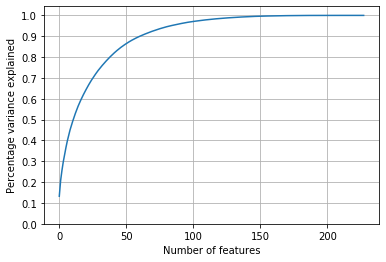

In [153]:
pca = PCA()
pca.fit(X_train_os.toarray())
## Determine the optimal number of compoents for PCA
percentage_var_expl = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_per_var = np.cumsum(percentage_var_expl)
plt.plot(cum_per_var)
plt.xlabel("Number of features")
plt.ylabel("Percentage variance explained")
plt.grid()
plt.yticks(list(np.linspace(0,1,11)))

About 95% of the data is explained by 100 principal components

In [154]:
pca = PCA(n_components = 100)
pca_data = pca.fit_transform(X_train_os.toarray())

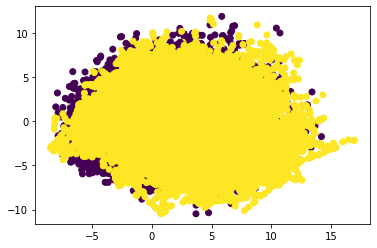

In [169]:
plt.scatter(pca_data[:,1], pca_data[:,2], c = y_train_os)

In [173]:
log_loss_metric = []

for i in alpha:
    sgd = SGDClassifier(alpha = i, loss = 'log', random_state=42)
    sgd_os = cross_validate(sgd, pca_data, y_train_os, scoring=scoring,
                         cv=3, return_train_score=True)
    sgd.fit(pca_data, y_train_os)
    sgd_cal = CalibratedClassifierCV(sgd)
    sgd_cal.fit(pca_data, y_train_os)
    #roc_metric.append(classification_metrics(sgd_cal,x_test, y_test)[-3])
    pca_test_data = pca.transform(x_test.toarray())
    log_loss_metric.append(classification_metrics(sgd_cal,pca_test_data, y_test)[-1])
    print("Alpha: ", i, "Log loss: ", classification_metrics(sgd_cal,pca_test_data, y_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1e-05 Log loss:  (0.08453336264702649, 0.4857864813644978, 0.09011147225753702, 0.4855692267333256, array([[8432, 8328],
       [ 814,  769]]), 17.214204483981472)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.0001 Log loss:  (0.08921729611384784, 0.5148452305748579, 0.09894060973499558, 0.5048389285321215, array([[8440, 8320],
       [ 768,  815]]), 17.112525351772742)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.001 Log loss:  (0.09128996692392503, 0.5230574857864814, 0.10519235161812533, 0.517773569715217, array([[8518, 8242],
       [ 755,  828]]), 16.94117437207823)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.01 Log loss:  (0.09034749034749034, 0.5173720783322805, 0.10317919720336871, 0.5131924143306643, array([[8514, 8246],
       [ 764,  819]]), 16.965652772095876)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  0.1 Log loss:  (0.09199375557537913, 0.5211623499684144, 0.1014189965218594, 0.5106078606675641, array([[8617, 8143],
       [ 758,  825]]), 16.760407774790057)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  1 Log loss:  (0.0867666815942678, 0.4895767530006317, 0.0945410405284258, 0.4933415827776329, array([[8603, 8157],
       [ 808,  775]]), 16.880916572894968)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Alpha:  10 Log loss:  (0.07700955593029792, 0.4327226784586229, 0.08377046657560314, 0.4544776164407932, array([[8550, 8210],
       [ 898,  685]]), 17.150179365411784)


In [172]:
pca_test_data

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Precision: 0.27189862160960426
Recall: 0.7725837018319647
Confusion matrix: [[13485  3275]
 [  360  1223]]


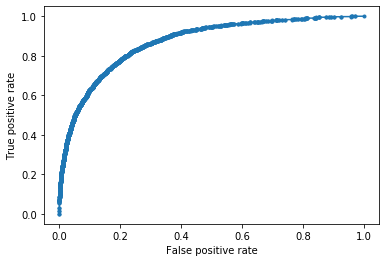

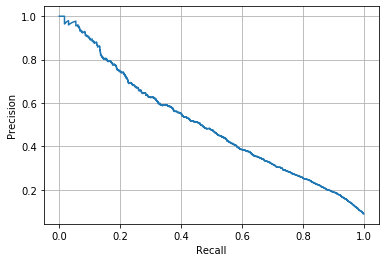

Area unde the curve for Precision-Recall Curve: 0.4989075844856886


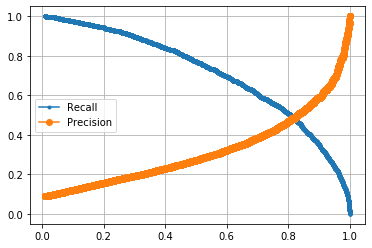

In [145]:
## Logistic regression with balanced data - oversampling and unweighted model
#lr_os.fit(X_train_os, y_train_os)
x_test = pipeline_full.transform(X_test)

lr_os_predict= lr_os.predict(x_test)
lr_os_predict_prob = lr_os.predict_proba(x_test)
print("Precision:",precision_score(y_test,lr_os_predict))
print("Recall:", recall_score(y_test,lr_os_predict))
print("Confusion matrix:", confusion_matrix(y_test,lr_os_predict))
fpr, tpr, threshold = roc_curve(y_test,lr_os_predict_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()
precision, recall, threshold = precision_recall_curve(y_test,lr_os_predict_prob[:,1])
plt.plot(recall, precision)
#plt.axhline(y=0.086302, linestyle='--', color = 'red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()
plt.plot(threshold, recall[1:], marker = '.', label = "Recall")
plt.plot(threshold, precision[1:], marker = 'o', label = "Precision")
plt.legend()
plt.grid()
print("Area unde the curve for Precision-Recall Curve:", auc(recall, precision))

In [79]:
## Logistic regression with imbalanced data and unweighted modelling
lr = LogisticRegression(penalty = 'l1', C = 0.8)
lr_cv = cross_val_score(lr, x_train, y_train, scoring = "roc_auc", cv = 5)
print("Averge CV score for Logistic Regression is {} +- {}".format(lr_cv.mean(), lr_cv.std()))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Averge CV score for Logistic Regression is 0.8826699145865946 +- 0.003392168526368627


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC score for Logistic regression is: 0.8779969002392666
Precision: 0.6836581709145427
Recall: 0.2880606443461781
Confusion matrix: [[16549   211]
 [ 1127   456]]


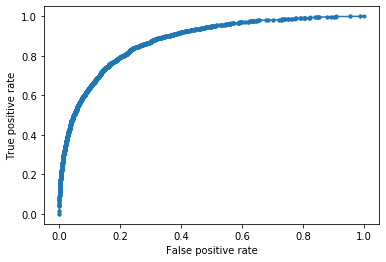

In [127]:
## Logistic regression with imbalanced data and unweighted modelling
lr.fit(x_train, y_train)
x_test = pipeline_full.transform(X_test)
y_predict = lr.predict(x_test)
lr_prob = lr.predict_proba(x_test)

print("ROC-AUC score for Logistic regression is:", roc_auc_score(y_test, lr_prob[:,1]))
fpr, tpr, threshold = roc_curve(y_test, lr_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

print("Precision:",precision_score(y_test,y_predict))
print("Recall:", recall_score(y_test,y_predict))
print("Confusion matrix:", confusion_matrix(y_test,y_predict))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC-AUC score for Logistic regression is: 0.8799505334875173
Precision: 0.28789300797747536
Recall: 0.7751105495893872
Confusion matrix: [[13725  3035]
 [  356  1227]]


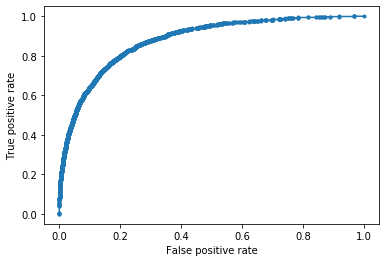

In [106]:
### ## Logistic regression with imbalanced data and modeled with class weights
lr_weight = LogisticRegression(penalty = 'l1', C = 0.8, class_weight='balanced')
lr_weight.fit(x_train, y_train)
y_predict_wt = lr_weight.predict(x_test)
lr_weight_prob = lr_weight.predict_proba(x_test)

print("ROC-AUC score for Logistic regression is:", roc_auc_score(y_test, lr_weight_prob[:,1]))
fpr, tpr, threshold = roc_curve(y_test, lr_weight_prob[:,1])
plt.plot(fpr,tpr, marker='.')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

print("Precision:",precision_score(y_test,y_predict_wt))
print("Recall:", recall_score(y_test,y_predict_wt))
print("Confusion matrix:", confusion_matrix(y_test,y_predict_wt))


- Logistic regression with Lasso regularization is used to perform feature selection
- ROC-AUC of the model is promising: 0.88
- Confusion matrix indicates that FN rate is high. Lets look at the precision-recall curve. It will be highly useful to understand the model fit, particularly for skewed or imblanaced dataset
- Precision score is 0.29 ==> model prediction for person's death is correct only 29% of the time. This indicates that this is a poor model
- Morever, recall is 0.77 => the model has detected only 77% of the patient death.
- Area under the PR-AUC is 0.5 -- indicating that it is a poor model. ROC-AUC is misleading in this scenario. To overcome this, let us oversample the minority data

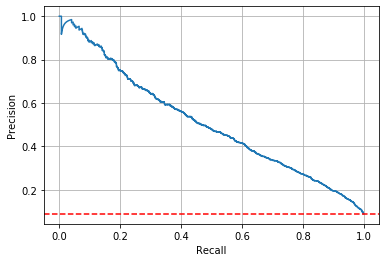

Area unde the curve for Precision-Recall Curve: 0.5098628338346509


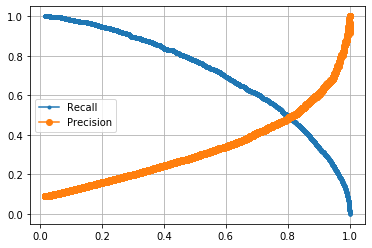

In [124]:
### ## Logistic regression with imbalanced data and modeled with class weights

precision, recall, threshold = precision_recall_curve(y_test, lr_weight_prob[:,1])
plt.plot(recall, precision)
plt.axhline(y=0.086302, linestyle='--', color = 'red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()
plt.plot(threshold, recall[1:], marker = '.', label = "Recall")
plt.plot(threshold, precision[1:], marker = 'o', label = "Precision")
plt.legend()
plt.grid()
print("Area unde the curve for Precision-Recall Curve:", auc(recall, precision))

In [ ]:
cat_columns = X_train_dum.select_dtypes(include = 'uint8').columns.tolist()
num_cols = X_train_dum.select_dtypes(exclude = 'uint8').columns.tolist()
final_cols = num_cols + cat_columns